In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import datetime

import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Apple Mobility Data
***

#### Functions:

In [2]:
def save_AMD_Italy():
    '''
    Generates the reduced CSV to speed up the loading time
    '''
    df = pd.read_csv("DATA/AMD/applemobilitytrends-2022-02-10.csv")
    df_out = applyfilter(df, {"country"  : ["Italy"], 
                              "geo_type" : ["sub-region"]})
    df_out.drop(["geo_type", "alternative_name", "sub-region", "country"], 1, inplace=True)
    #driving_norm, walking_norm = 0, 0
    # The following try except are implemented due to the fact that some regions lack the walking data
    #for region in region_name:
    #    
    #    try:
    #        walking_values += applyfilter(df_out, {"region" : [region], "transportation_type" : ["walking"]}).iloc[:,2:].values.flatten() * weight_dict[region]
    #    except Exception:
    #        pass
    #    else:
    #        walking_norm += weight_dict[region]
    #print(driving_norm,walking_norm)
    #df_tmp = pd.DataFrame([["Italy", "driving", *driving_values/driving_norm],
    #                       ["Italy", "walking", *walking_values/walking_norm]], columns=df_out.columns)
    #df_out = pd.concat([df_out, df_tmp], ignore_index=True)
    df_out.to_csv("DATA/AMD/applemobilitytrends_ITA-2022-02-10.csv", index=False)

def load_AMD_Italy():
    '''
    Load the AMD referred to Italy and return the dataframe and the dates, 
    and eventually saves the list of all possible cities/regions
    '''
    df = pd.read_csv("DATA/AMD/applemobilitytrends_ITA-2022-02-10.csv")
    dates_str  = df.columns[2:] # list of sting
    return df, dates_str

def applyfilter(df, dictionary):
    '''
    Filter the dataframe according to the dictionary: the values needs to be a list
    The order matter
    '''
    df_out = df.copy()
    for key in dictionary.keys():
        sub_df = [df_out.loc[df_out[key] == val] for val in dictionary[key]]
        df_out = pd.concat(sub_df, ignore_index=True)

    return df_out

def fill_missing(df):
    '''
    AMD driving are missing for the 2020-05-11, 2020-05-12 
    AMD are missing for the 2021-03-12
    '''
    df_driv = df.loc[df["transportation_type"] == "driving", ["2020-05-10","2020-05-13"]]
    values = (df_driv["2020-05-10"].values + df_driv["2020-05-13"].values)/2
    df.loc[df["transportation_type"] == "driving", "2020-05-11"] = values
    df.loc[df["transportation_type"] == "driving", "2020-05-12"] = values
    df["2021-03-12"] = (df["2021-03-11"] + df["2021-03-13"])/2

def transform_week_RAVG(dataframe, cols, window=7):
    '''
    Substitute the mobility data with it's rolling average
    '''
    values = dataframe[cols].values
    RAVG = np.array([values[:,ii-window:ii].sum(axis=1)/window for ii in np.arange(window,len(cols)+1)]).T
    dataframe[cols[:window-1]] = np.NaN
    dataframe[cols[window-1:]] = RAVG
    
def from_to(date_list, start, end):
    '''
    Return the indexes of a date list corresponding to the period between start and end
    '''
    a = list(date_list).index(start)
    b = list(date_list).index(end)
    return slice(a,b+1), np.arange(a,b+1)   # we need np because integer operation are not allowed on range object

#### Examples:

In [3]:
# Obviously needs to be run just the first time to generate the CVS
#save_AMD_Italy()
df_amd, dates_str_amd = load_AMD_Italy()
fill_missing(df_amd)
transform_week_RAVG(df_amd, dates_str_amd)
region_list_amd = np.unique(df_amd["region"].values)
dates_datetime_amd = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in dates_str_amd]
df_amd.head()

region transportation_type  2020-01-13  2020-01-14  \
0                  Abruzzo Region             driving         NaN         NaN   
1                  Abruzzo Region             walking         NaN         NaN   
2                   Apulia Region             driving         NaN         NaN   
3                   Apulia Region             walking         NaN         NaN   
4  Autonomous Region Aosta Valley             driving         NaN         NaN   

   2020-01-15  2020-01-16  2020-01-17  2020-01-18  2020-01-19  2020-01-20  \
0         NaN         NaN         NaN         NaN  106.295714  106.267143   
1         NaN         NaN         NaN         NaN  111.790000  113.278571   
2         NaN         NaN         NaN         NaN  106.478571  106.725714   
3         NaN         NaN         NaN         NaN  110.544286  110.660000   
4         NaN         NaN         NaN         NaN  138.260000  138.518571   

   ...  2022-02-01  2022-02-02  2022-02-03  2022-02-04  2022-02-05  \
0  ...  138.440000  137.808571  137.991429  137.358571  136.084286   
1  ...  175.931429  176.121429  174.678571  172.627143  168.042857   
2  ...  129.600000  129.788571  130.055714  130.615714  131.090000   
3  ...  150.231429  151.904286  152.297143  152.602857  154.515714   
4  ...  184.881429  184.214286  185.864286  186.568571  183.064286   

   2022-02-06  2022-02-07  2022-02-08  2022-02-09  2022-02-10  
0  133.504286  134.070000  134.352857  135.762857  136.315714  
1  164.775714  163.804286  164.785714  165.158571  167.681429  
2  131.641429  132.187143  133.182857  134.434286  136.601429  
3  155.550000  155.257143  156.937143  158.192857  161.128571  
4  179.954286  180.338571  182.091429  183.322857  183.782857  

[5 rows x 762 columns]

In [4]:
print(region_list_amd)

['Abruzzo Region' 'Apulia Region' 'Autonomous Region Aosta Valley'
 'Autonomous Region Friuli-Venezia Giulia' 'Autonomous Region Sardinia'
 'Autonomous Region Trentino-Alto Adige/Südtirol' 'Basilicata Region'
 'Calabria Region' 'Campania Region' 'Emilia-Romagna Region'
 'Lazio Region' 'Liguria Region' 'Lombardy Region' 'Marche Region'
 'Molise Region' 'Piedmont Region' 'Sicily Region' 'Tuscany Region'
 'Umbria Region' 'Veneto Region']


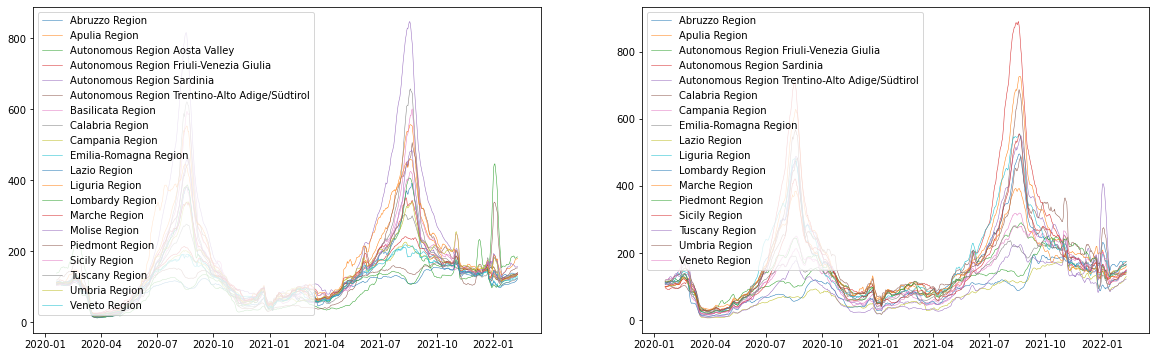

In [5]:
fig, ax = plt.subplots(1,2, figsize=[20,6])
for region in region_list_amd:
    try:
        ax[0].plot(dates_datetime_amd, applyfilter(df_amd, {"region" : [region]}).iloc[0,2:], label=region, linewidth=0.5)
    except Exception:
        pass
    
    try:
        ax[1].plot(dates_datetime_amd, applyfilter(df_amd, {"region" : [region]}).iloc[1,2:], label=region, linewidth=0.5)
    except Exception:
        pass
ax[0].legend()
ax[1].legend()
plt.show()

In [6]:
# To get the indexes of a given windows of time
#window_slice, window_mask = from_to(dates_list,"2020-03-21","2020-05-03")  # to a list we can just apply a slice

#fig, ax = plt.subplots(1,2, figsize=[20,6])

#ax[0].plot(dates_datetime[window_slice], applyfilter(df_ita, {"region" : ["Italy"]}).iloc[0,window_mask+2], linewidth=0.5)

#ax[1].plot(dates_datetime, applyfilter(df_ita, {"region" : ["Italy"]}).iloc[1,2:], linewidth=0.5)

#ax[0].legend()
#ax[1].legend()
#plt.show()

## Protezione civile
***

#### Functions:

In [7]:
def save_prot_civ():
    df = pd.read_csv("DATA/prot_civ/itaregioni.csv")
    #df = df[['data', 'denominazione_regione', 'nuovi_positivi', 'totale_casi']]
    df = df[['data', 'denominazione_regione', 'nuovi_positivi', 'totale_casi', 'ricoverati_con_sintomi', 'ingressi_terapia_intensiva', 'tamponi']]
    df_trentino = df[(df['denominazione_regione'] == 'P.A. Bolzano') | (df['denominazione_regione'] == 'P.A. Trento')].groupby('data', as_index = False).sum()
    df_trentino['denominazione_regione'] = 'Trentino alto adige' 
    df_prot_civ = pd.concat([df, df_trentino], ignore_index=True)
    df_prot_civ = df_prot_civ[(df_prot_civ['denominazione_regione'] != 'P.A. Bolzano') & (df_prot_civ['denominazione_regione'] != 'P.A. Trento')]
    #df_prot_civ = df ## remove to backup
    df_prot_civ['data'] = [date.split('T')[0] for date in df_prot_civ['data']]
    df_prot_civ.to_csv("DATA/prot_civ/itaregioni_final.csv", index=False)

def load_prot_civ():
    '''
    '''
    df = pd.read_csv("DATA/prot_civ/itaregioni_final.csv")
    dates_str = np.unique(df["data"])
    return df, dates_str

#### Examples:

In [8]:
# To run just the first time
save_prot_civ()
df_pc, dates_str_pc = load_prot_civ()
region_list_pc = np.unique(df_pc["denominazione_regione"].values)
dates_datetime_pc = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in dates_str_pc]
df_pc.head()
#dates_datetime_pc

data denominazione_regione  nuovi_positivi  totale_casi  \
0  2020-02-24               Abruzzo               0            0   
1  2020-02-24            Basilicata               0            0   
2  2020-02-24              Calabria               0            0   
3  2020-02-24              Campania               0            0   
4  2020-02-24        Emilia-Romagna              18           18   

   ricoverati_con_sintomi  ingressi_terapia_intensiva  tamponi  
0                       0                         NaN        5  
1                       0                         NaN        0  
2                       0                         NaN        1  
3                       0                         NaN       10  
4                      10                         NaN      148

In [9]:
region_sorted_pc = ["Abruzzo", "Puglia", "Valle d'Aosta", "Friuli Venezia Giulia",
                    "Sardegna", "Trentino alto adige", "Basilicata", "Calabria", 
                    "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Lombardia", 
                    "Marche", "Molise", "Piemonte", "Sicilia", "Toscana", "Umbria", "Veneto"]

region_dict = dict(sorted({key : value for key,value in zip(region_sorted_pc, region_list_amd)}.items()))
region_dict

{'Abruzzo': 'Abruzzo Region',
 'Basilicata': 'Basilicata Region',
 'Calabria': 'Calabria Region',
 'Campania': 'Campania Region',
 'Emilia-Romagna': 'Emilia-Romagna Region',
 'Friuli Venezia Giulia': 'Autonomous Region Friuli-Venezia Giulia',
 'Lazio': 'Lazio Region',
 'Liguria': 'Liguria Region',
 'Lombardia': 'Lombardy Region',
 'Marche': 'Marche Region',
 'Molise': 'Molise Region',
 'Piemonte': 'Piedmont Region',
 'Puglia': 'Apulia Region',
 'Sardegna': 'Autonomous Region Sardinia',
 'Sicilia': 'Sicily Region',
 'Toscana': 'Tuscany Region',
 'Trentino alto adige': 'Autonomous Region Trentino-Alto Adige/Südtirol',
 'Umbria': 'Umbria Region',
 "Valle d'Aosta": 'Autonomous Region Aosta Valley',
 'Veneto': 'Veneto Region'}

## Colors
***

In [10]:
def generate_tseries(df):
    
    start_date = df.iloc[0,0]
    out = {'bianco'    : [],
           'giallo'    : [],
           'arancione' : [],
           'rosso'     : []}
    
    for row in range(1,len(df)-1):
        curr_date  = df.iloc[row,0]
        curr_color = df.iloc[row,2]
        # if new color
        if (curr_color != df.iloc[row-1,2]):
            start_date = curr_date
        # if last color
        if (curr_color != df.iloc[row+1,2]):
            out[curr_color].append((start_date, curr_date))
    out[df.iloc[row,2]].append((start_date, df.iloc[row,0]))
    return out

In [11]:
colors = pd.read_csv('DATA/dataset_colori.csv')
prova = generate_tseries(applyfilter(colors, {'denominazione_regione' : ['Provincia autonoma Bolzano']}))
colors

data denominazione_regione     colore
0     2020-11-06               Abruzzo     giallo
1     2020-11-07               Abruzzo     giallo
2     2020-11-08               Abruzzo     giallo
3     2020-11-09               Abruzzo     giallo
4     2020-11-10               Abruzzo  arancione
...          ...                   ...        ...
9823  2022-02-12                Veneto     giallo
9824  2022-02-13                Veneto     giallo
9825  2022-02-14                Veneto     giallo
9826  2022-02-15                Veneto     giallo
9827  2022-02-16                Veneto     giallo

[9828 rows x 3 columns]

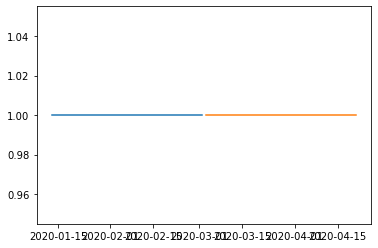

In [12]:
plt.plot(dates_datetime_amd[:50], np.ones(50))
plt.plot(dates_datetime_amd[50:100], np.ones(50))

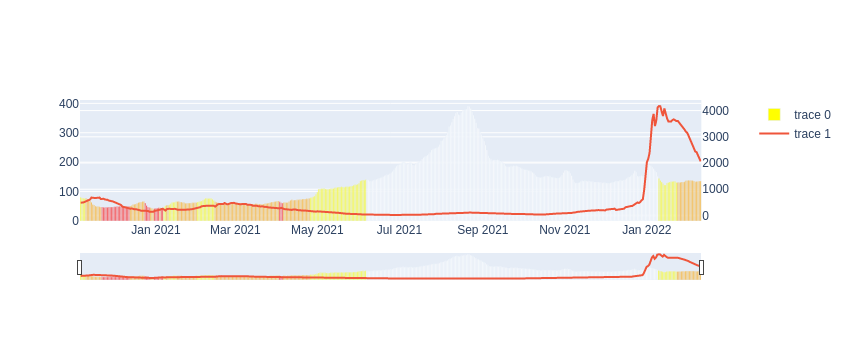

In [14]:
from plotly.subplots import make_subplots

df_mob = applyfilter(df_amd, {"region" : [region_dict['Abruzzo']]}).iloc[:, 2:]
df_col = applyfilter(colors, {'denominazione_regione' : ['Abruzzo']})
df_inc = applyfilter(df_pc, {"denominazione_regione" : ['Abruzzo']}).iloc[:,2:].rolling(window=7).mean()
translate = {'bianco'    : 'white',
             'giallo'    : 'yellow',
             'arancione' : 'orange',
             'rosso'     : 'red'}
color_list = [translate[col] for col in df_col.colore.values]
start_date = df_col.iloc[0,0]
end_date   = dates_str_amd[-1]
slice_mob, mask_mob = from_to(dates_str_amd, start_date, end_date)
_, mask_col = from_to(df_col.data.values, start_date, end_date)
_, mask_inc = from_to(dates_str_pc, start_date, end_date)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=dates_datetime_amd[slice_mob], y=df_mob.iloc[0,mask_mob], marker_color=color_list), secondary_y=False)
fig.add_trace(go.Scatter(x=dates_datetime_amd[slice_mob], y=df_inc.iloc[mask_inc, 0]), secondary_y=True)

fig.update_xaxes(rangeslider_visible=True)
fig.update_yaxes(fixedrange=False)
fig.show()#render='jupyterlab')

In [43]:
colori

['blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue']

# LAG-time Analysis
***

## Correlation test
***

#### Functions

In [33]:
def kendall_lag_correlation(x_df, x_dates, y_df, y_dates, start, stop, n_lags):
    '''
    '''
    lags = np.arange(n_lags)
    correlation = {"driving" : {"incidence"  : np.zeros(n_lags), 
                                "prevalence" : np.zeros(n_lags),
                                "terapia_in" : np.zeros(n_lags)}, 
                   "walking" : {"incidence"  : np.zeros(n_lags), 
                                "prevalence" : np.zeros(n_lags),
                                "terapia_in" : np.zeros(n_lags)}}
    
    x_window_slice, x_window_mask = from_to(x_dates, start, stop)
    y_window_slice, y_window_mask = from_to(y_dates, start, stop)
    
    x = x_df.iloc[:, x_window_mask+2].values
    y = y_df.iloc[:,2:].rolling(window=7).mean()
    
    for lag in lags:    
        correlation['driving']['incidence'][lag]   = ss.kendalltau(x[0], y.iloc[lag+y_window_mask,0].values)[0]
        correlation['driving']['prevalence'][lag]  = ss.kendalltau(x[0], y.iloc[lag+y_window_mask,1].values)[0]
        correlation['driving']['terapia_in'][lag]  = ss.kendalltau(x[0], y.iloc[lag+y_window_mask,3].values)[0]
        try:
            correlation['walking']['incidence'][lag]   = ss.kendalltau(x[1], y.iloc[lag+y_window_mask,0].values)[0]
            correlation['walking']['prevalence'][lag]  = ss.kendalltau(x[1], y.iloc[lag+y_window_mask,1].values)[0]
            correlation['walking']['terapia_in'][lag]  = ss.kendalltau(x[1], y.iloc[lag+y_window_mask,3].values)[0]
        except Exception:
            pass
    return correlation

In [64]:
stat = kendall_lag_correlation(applyfilter(df_amd, {"region" : [region_dict['Abruzzo']]}), dates_str_amd,
                               applyfilter(df_pc, {"denominazione_regione" : ['Abruzzo']}), dates_str_pc,
                               '2022-01-10', '2022-01-23', 30)

IndexError: positional indexers are out-of-bounds

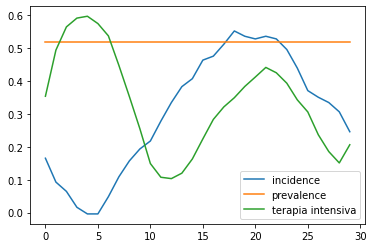

In [36]:
plt.plot(stat['driving']['incidence'], label = 'incidence')
plt.plot(stat['driving']['prevalence'], label = 'prevalence')
plt.plot(stat['driving']['terapia_in'], label = 'terapia intensiva')
plt.legend()

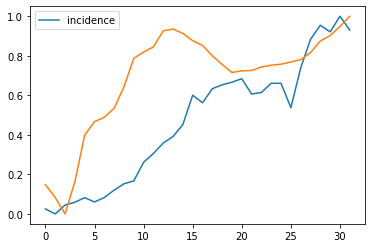

In [37]:
start = '2021-01-04'
stop  = '2021-02-04'
x_window_slice, x_window_mask = from_to(dates_str_amd, start, stop)
y_window_slice, y_window_mask = from_to(dates_str_pc, start, stop)
a = applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[y_window_mask+16,0].values
b = applyfilter(df_amd, {"region" : ["Abruzzo Region"]}).iloc[0, x_window_mask+2].values
a = (a - a.min()) / (a.max() - a.min())
b = (b - b.min()) / (b.max() - b.min())
plt.plot(a, label="incidence")
plt.plot(b)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


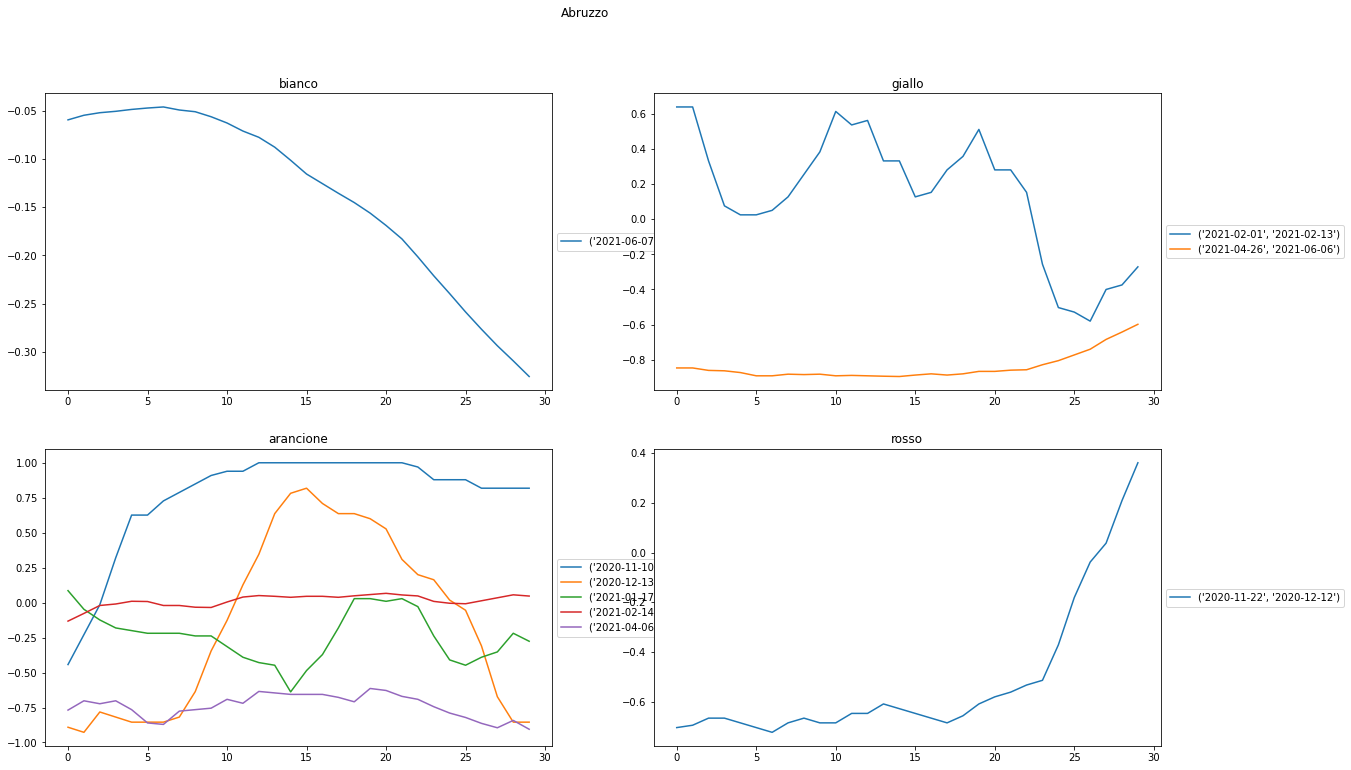

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


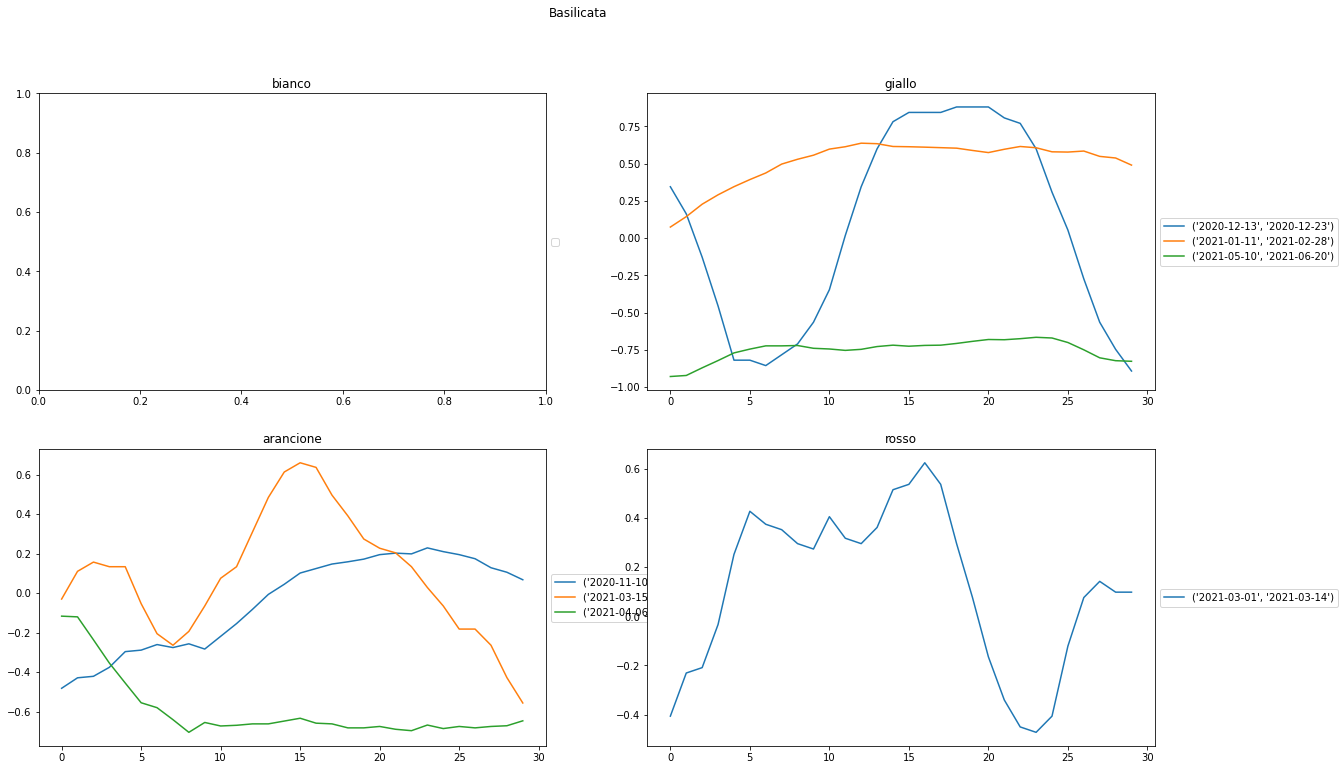

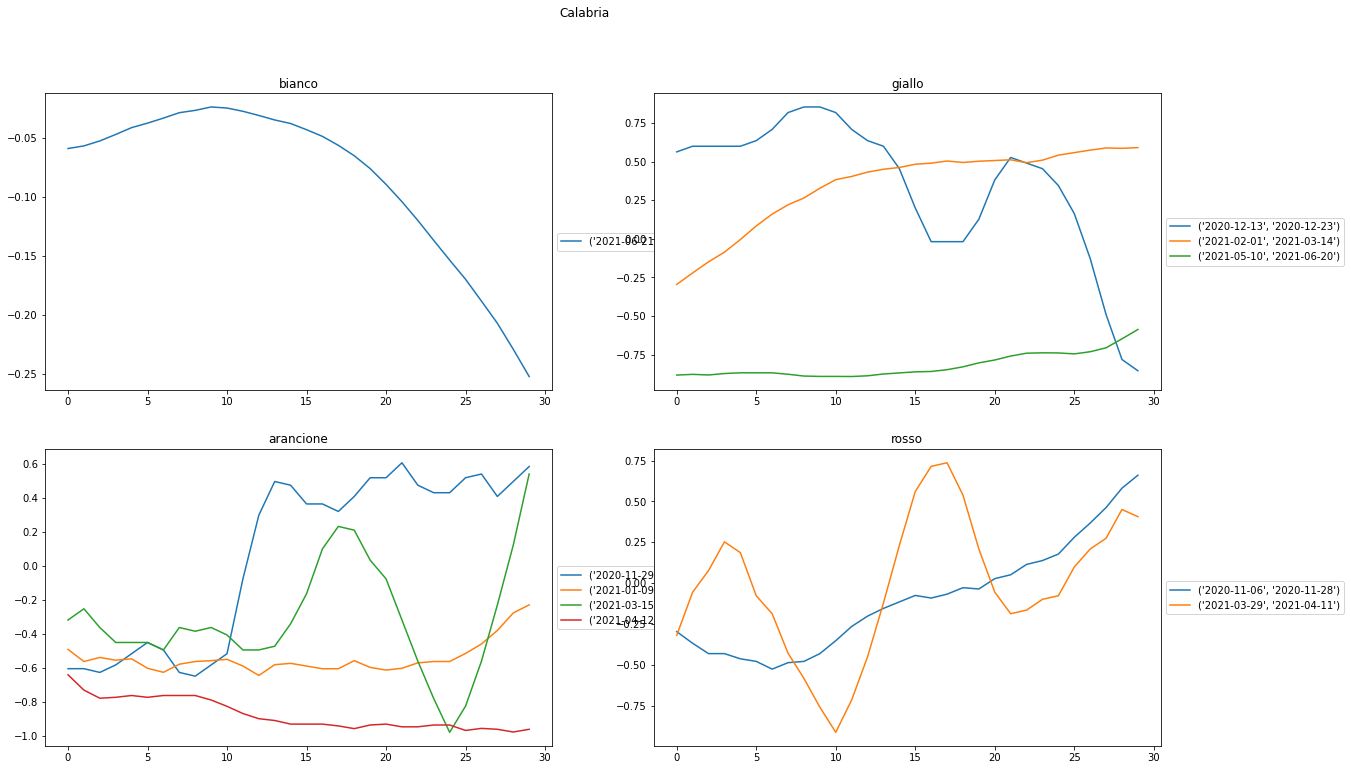

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


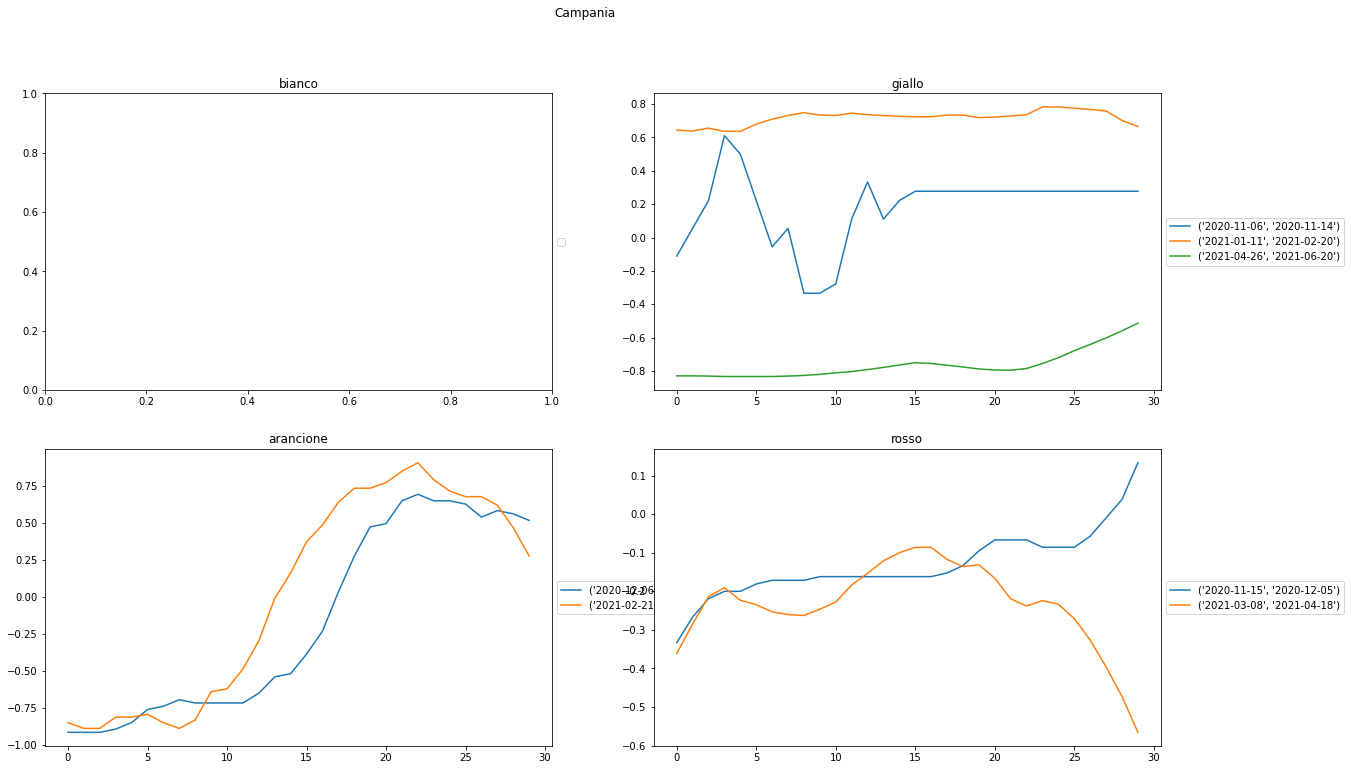

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


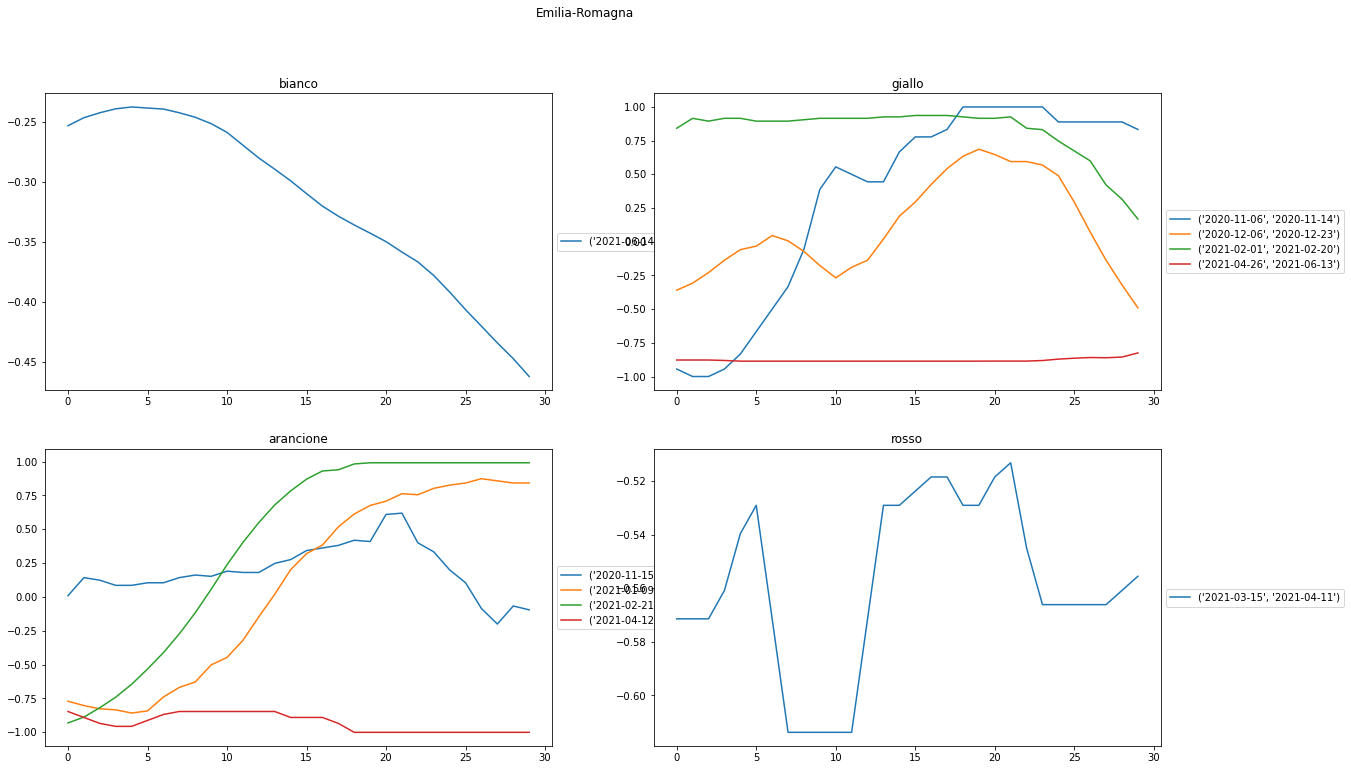

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


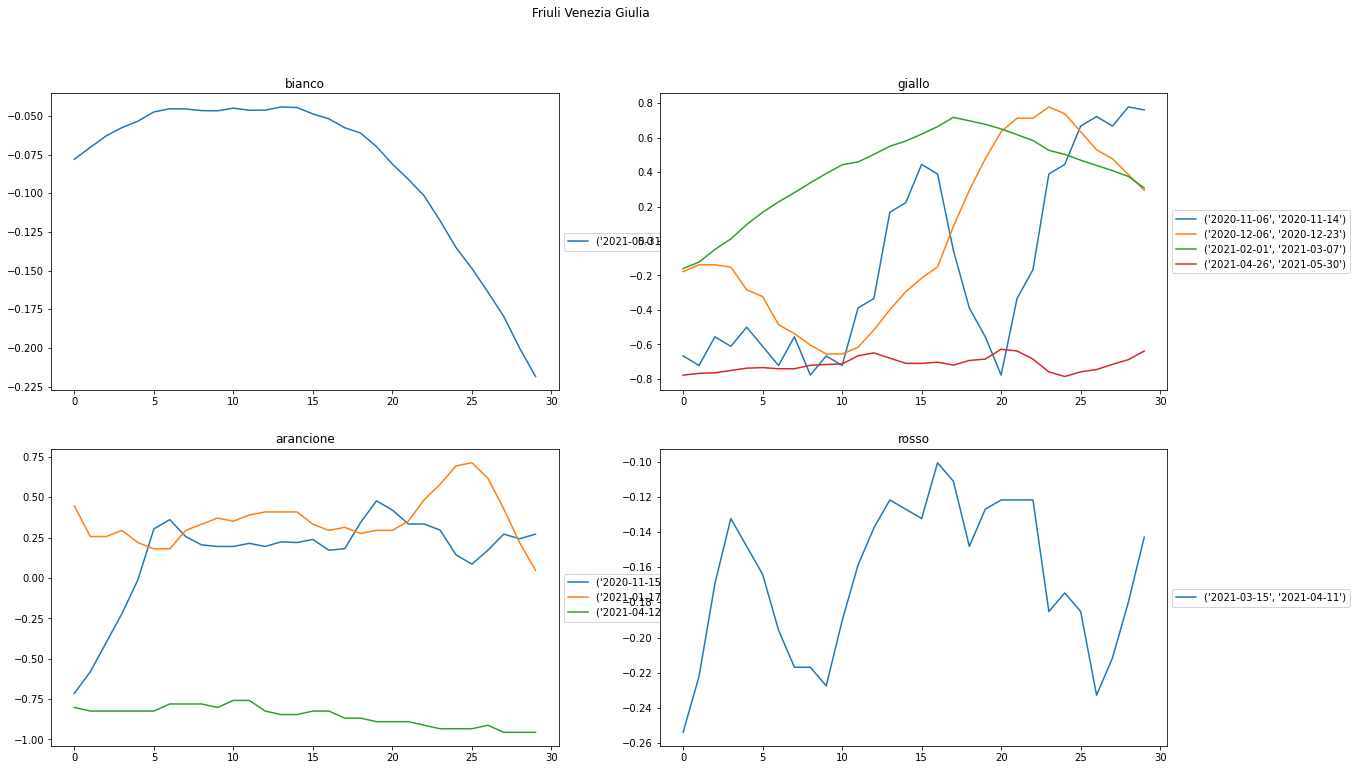

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


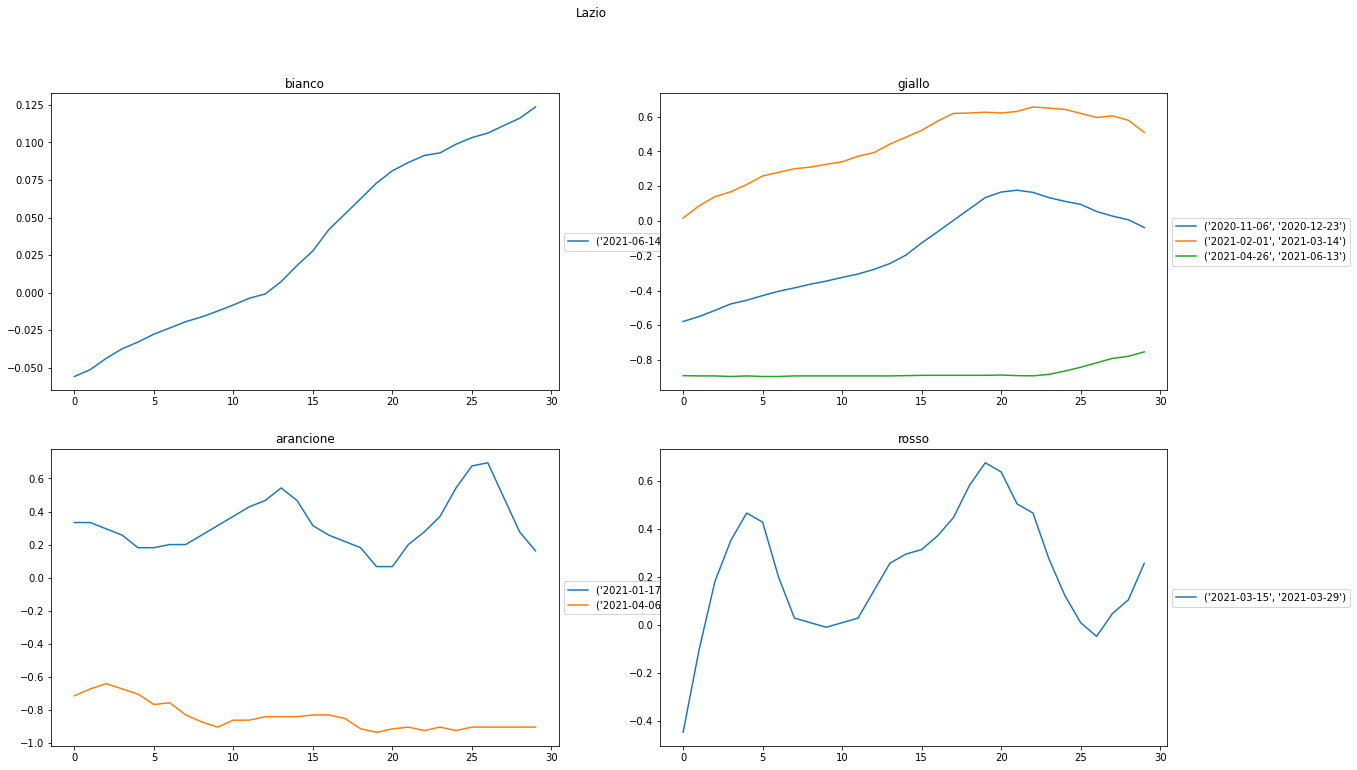

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


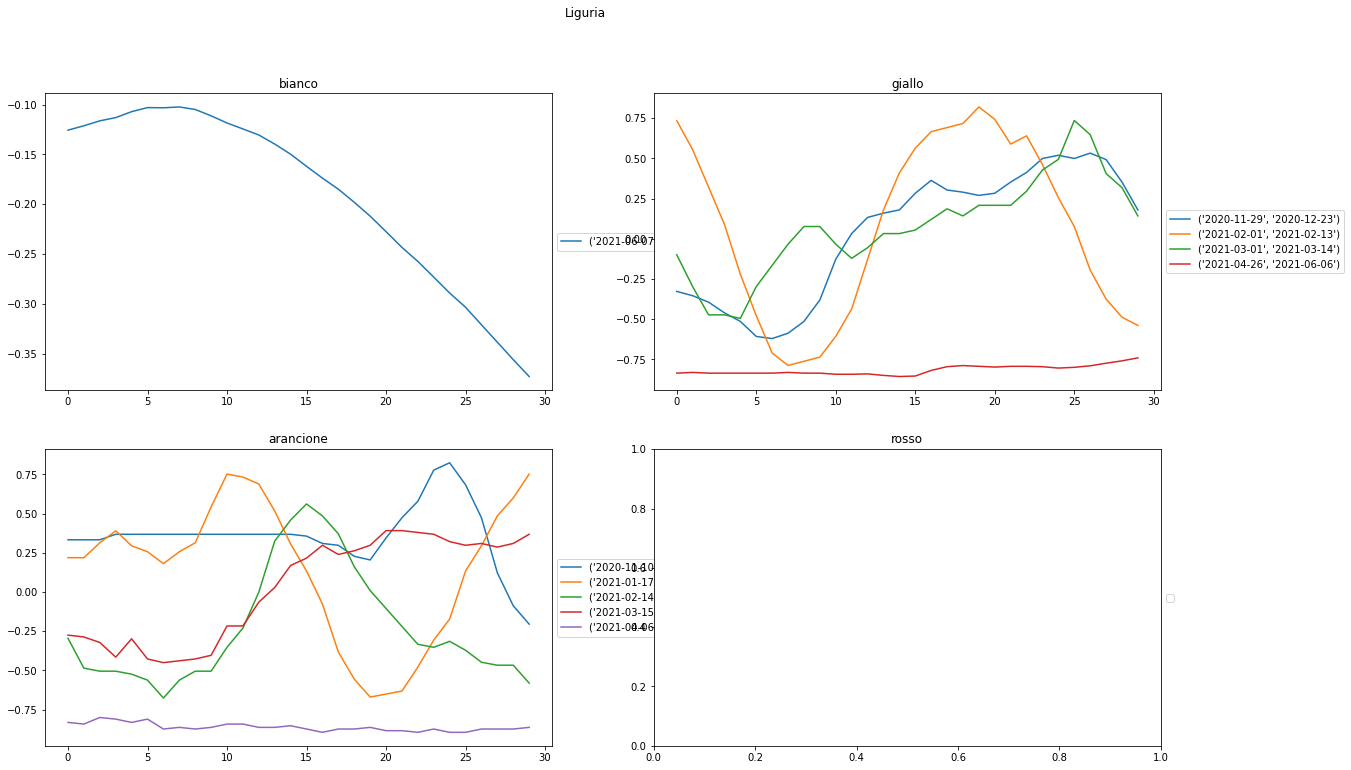

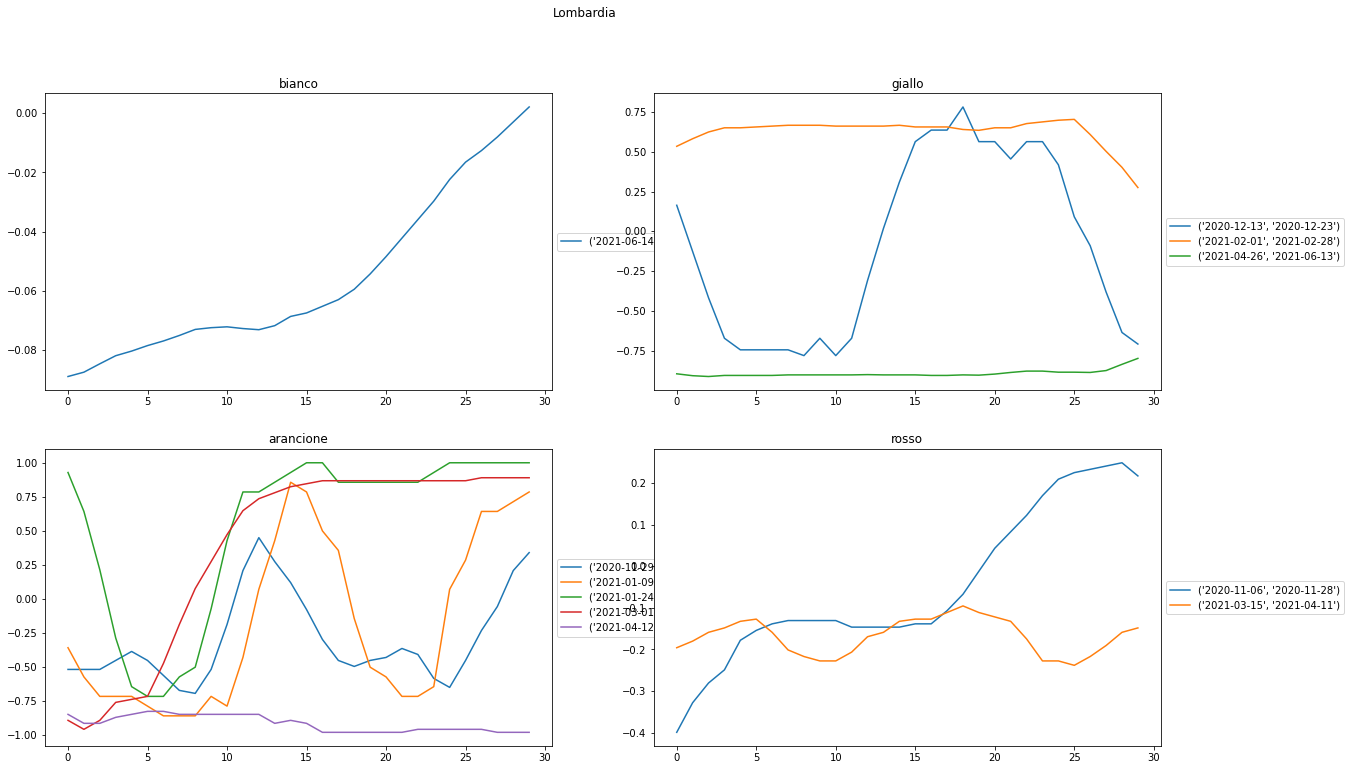

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


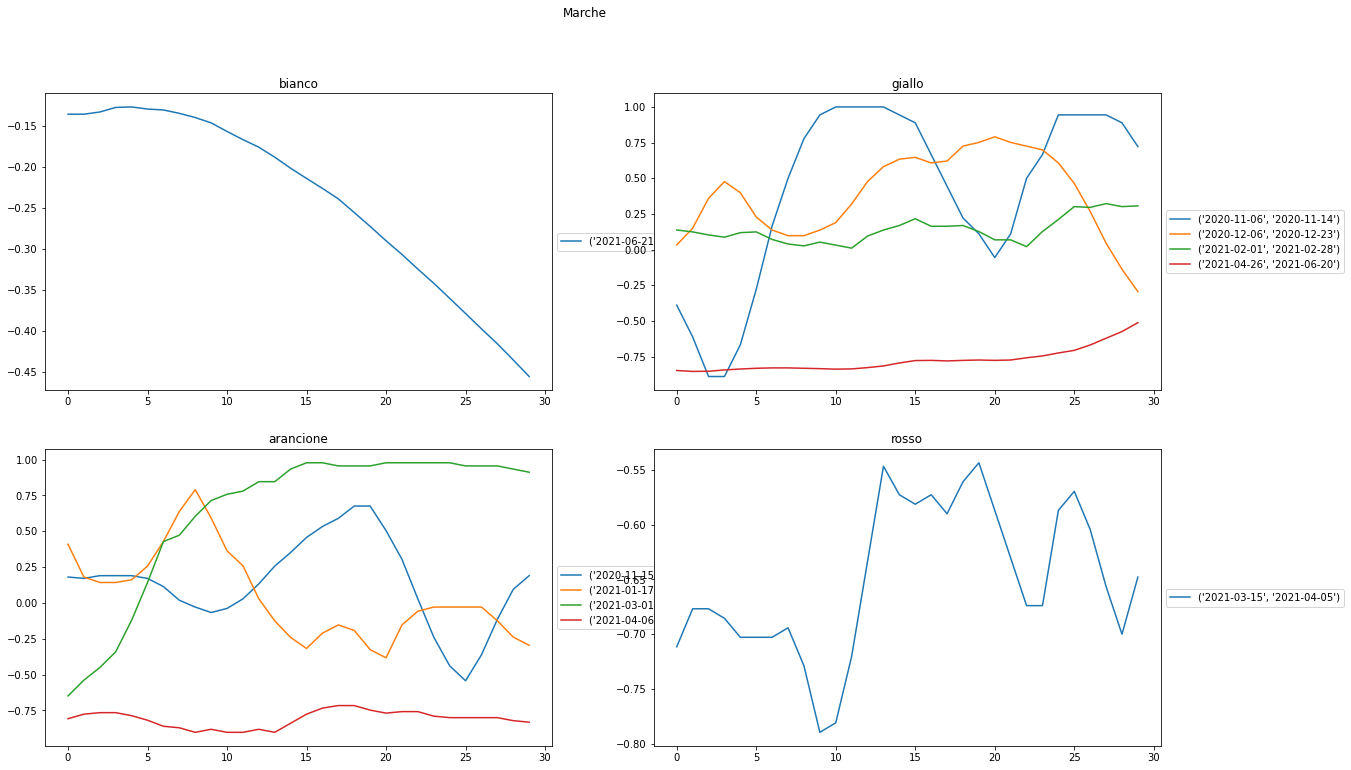

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

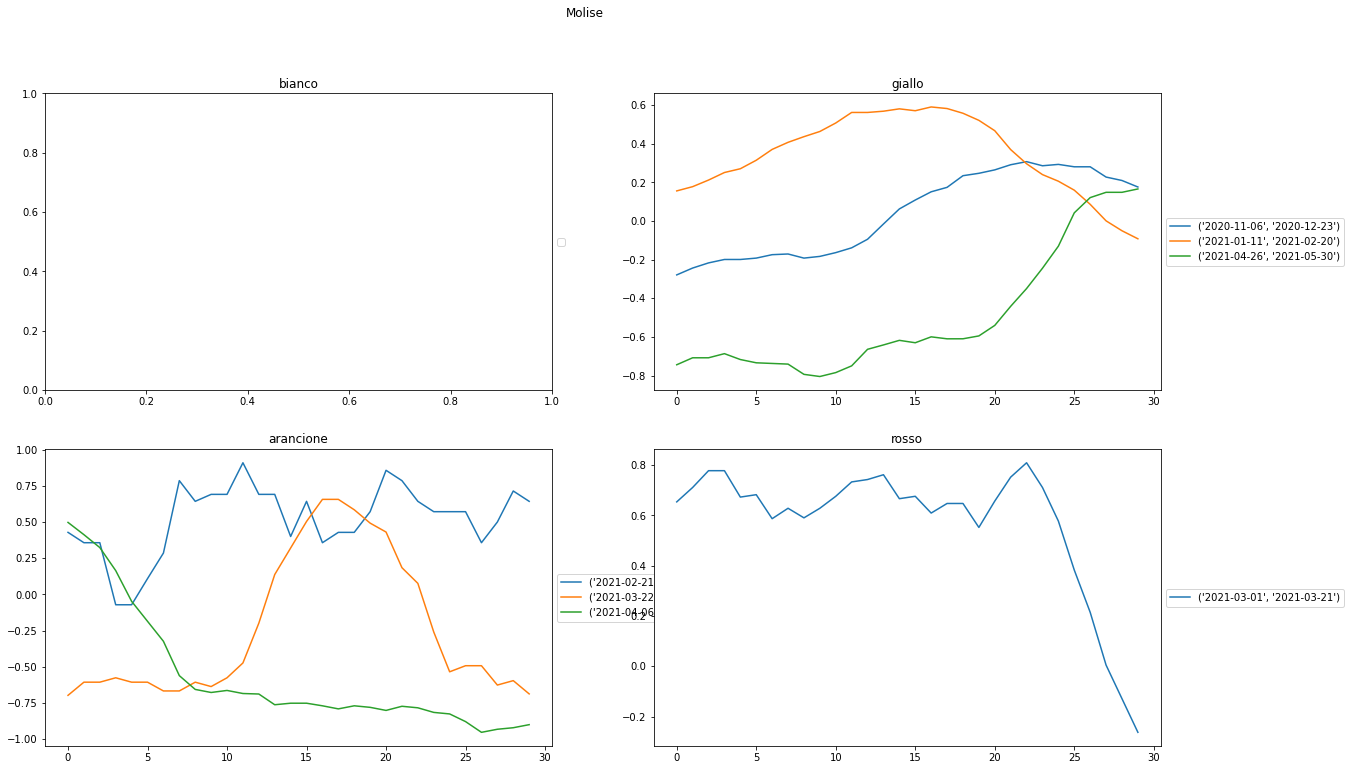

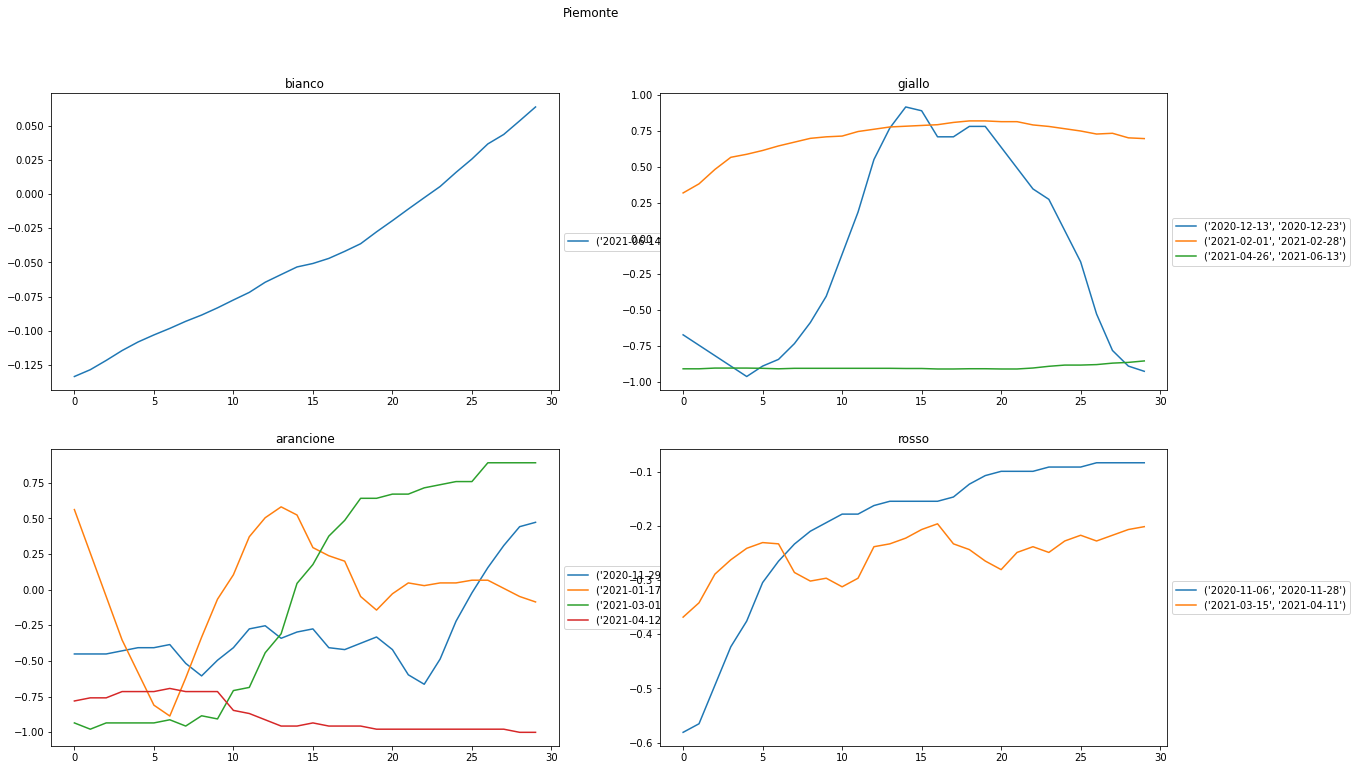

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


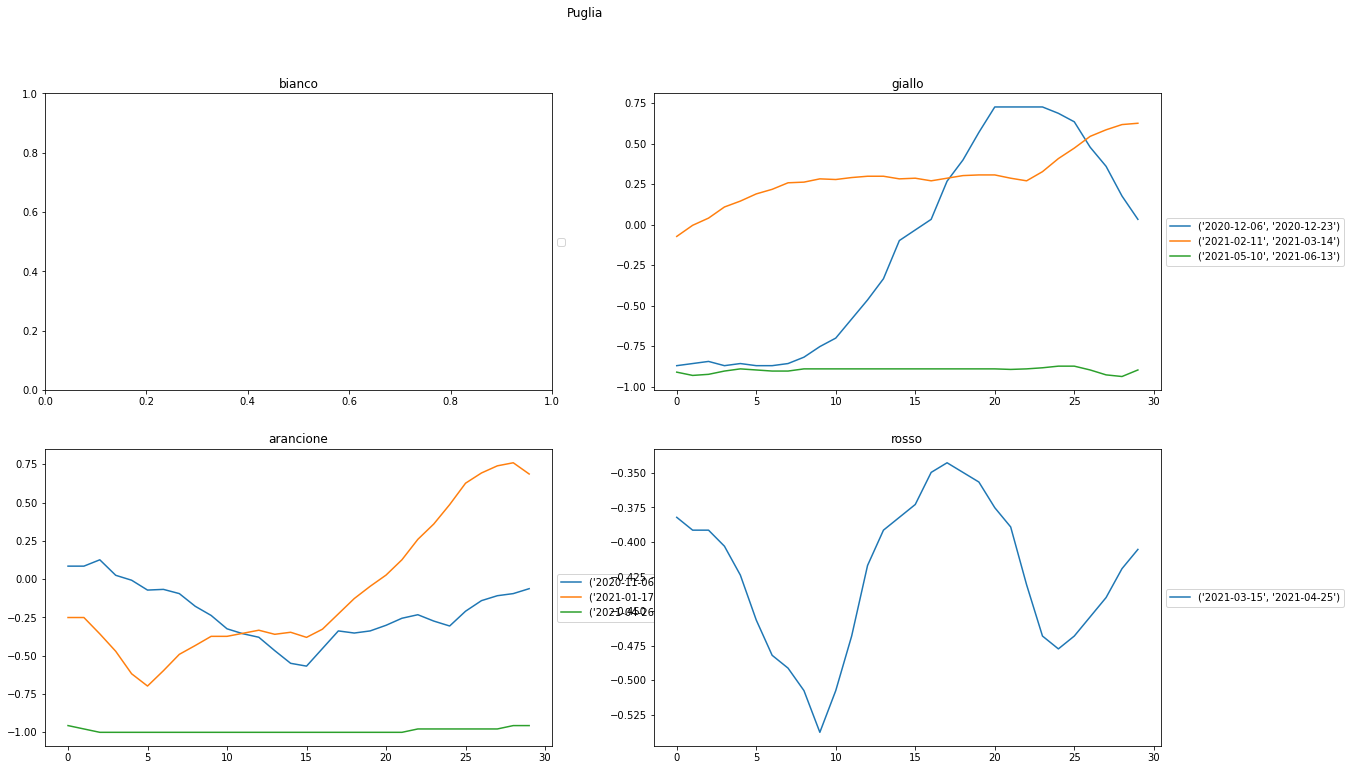

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

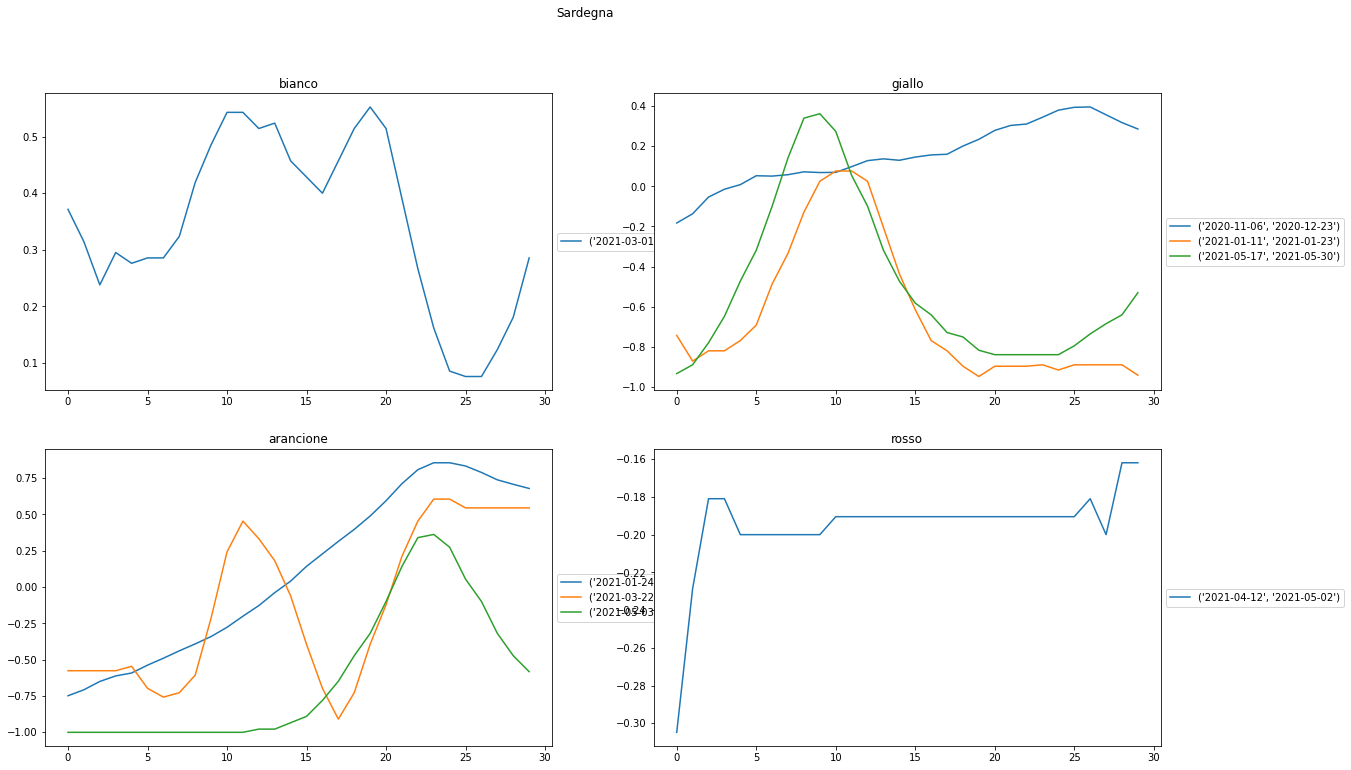

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


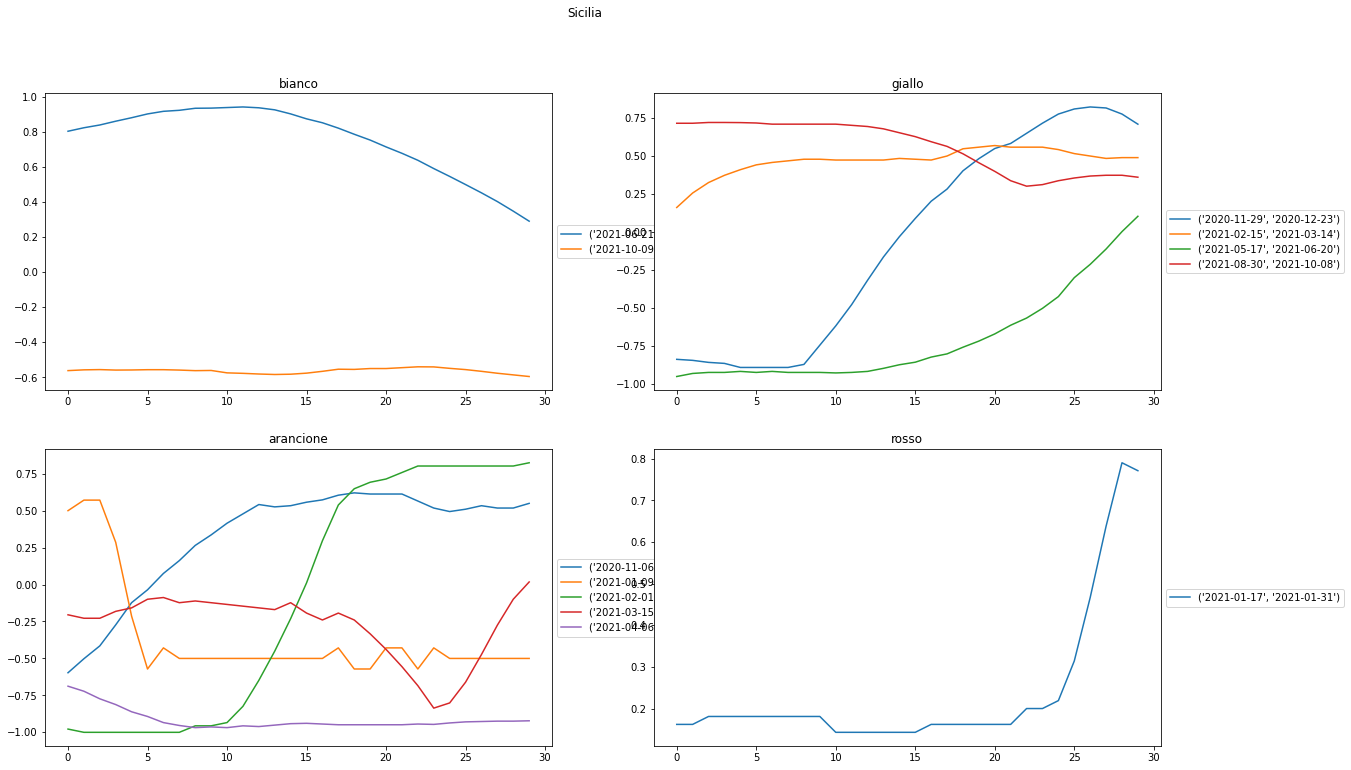

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


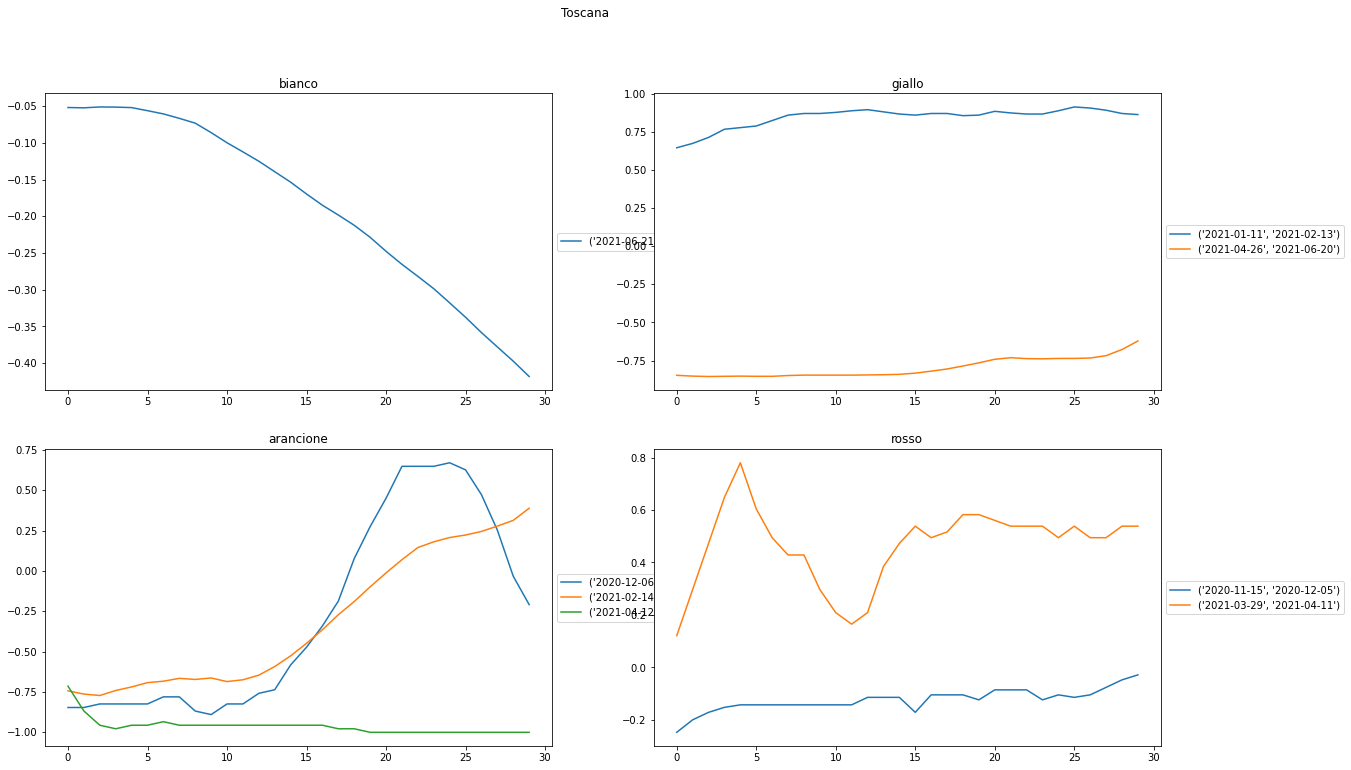

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


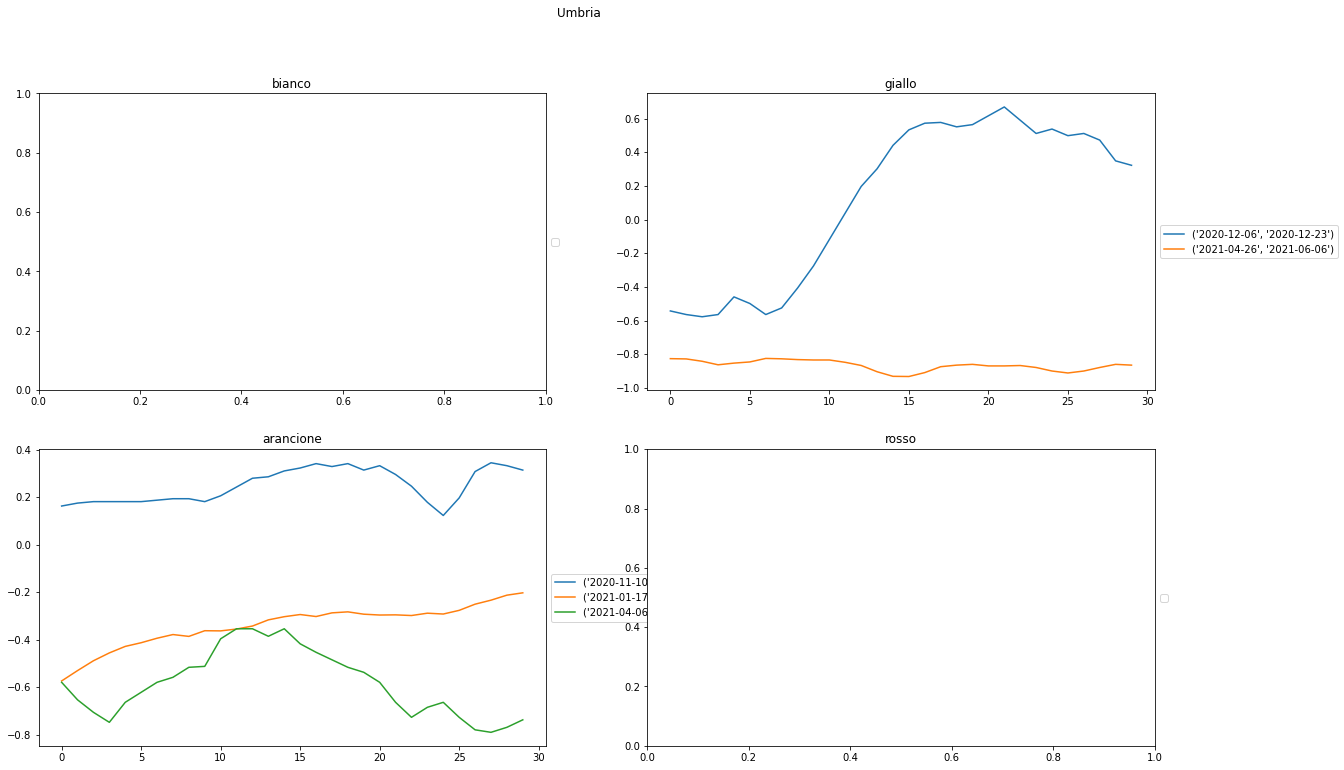

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


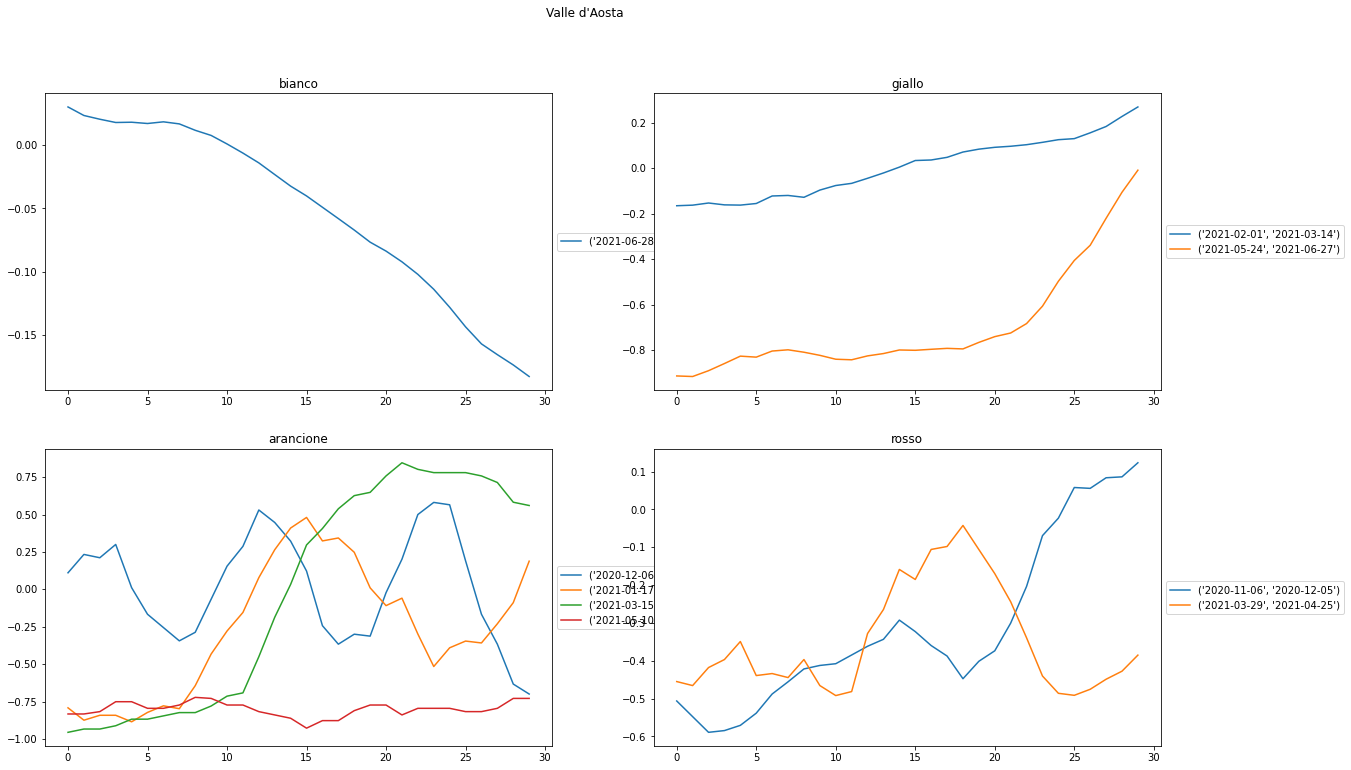

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


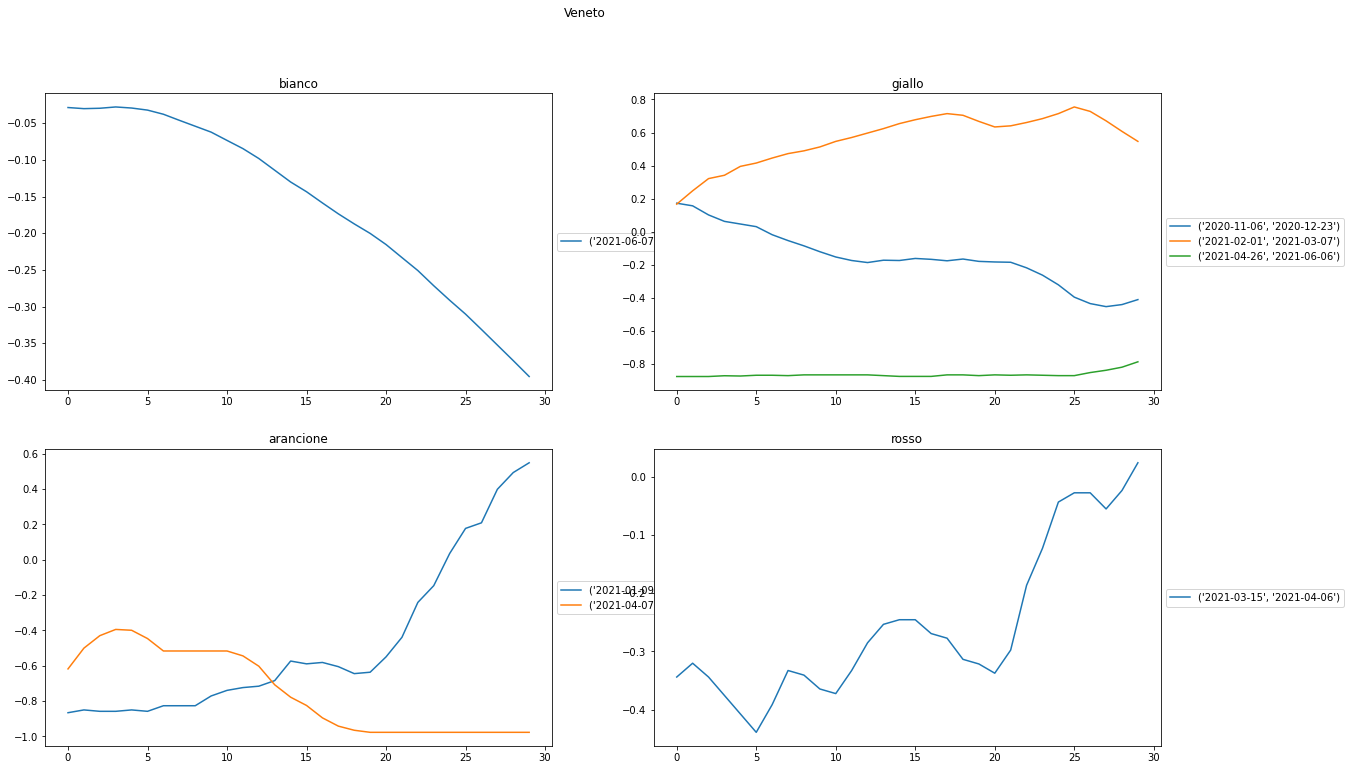

In [92]:
actual_regions = list(region_dict.keys())
acrual_regions = actual_regions.remove('Trentino alto adige')

for region in actual_regions:

    fig, ax = plt.subplots(2,2, figsize=[20,12])
    actual_dict = generate_tseries(applyfilter(colors, {'denominazione_regione' : [region]}))

    for ix,color in enumerate(actual_dict.keys()):
        for pair in actual_dict[color]:
            start, stop = pair
            if ((datetime.datetime.strptime(stop, "%Y-%m-%d").date() - datetime.datetime.strptime(start, "%Y-%m-%d").date()).days >= 7):
                try :
                    stat = kendall_lag_correlation(applyfilter(df_amd, {"region" : [region_dict[region]]}), dates_str_amd,
                                           applyfilter(df_pc, {"denominazione_regione" : [region]}), dates_str_pc,
                                           start, stop, 30)
                    ax[ix//2, ix%2].plot(stat['driving']['incidence'], label = pair)
                    #ax[ix//2, ix%2].plot(stat['walking']['incidence'], '--', label = pair)
                except Exception:
                    pass
            ax[ix//2, ix%2].set_title(color)
            ax[ix//2, ix%2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.suptitle(region)
    plt.show()

In [72]:
np.unique(colors.denominazione_regione)

array(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'Piemonte', 'Provincia autonoma Bolzano',
       'Provincia autonoma Trento', 'Puglia', 'Sardegna', 'Sicilia',
       'Toscana', 'Umbria', "Valle d'Aosta", 'Veneto'], dtype=object)

In [90]:
a = list(region_dict.keys())
a.remove('Abruzzo')
a

['Basilicata',
 'Calabria',
 'Campania',
 'Emilia-Romagna',
 'Friuli Venezia Giulia',
 'Lazio',
 'Liguria',
 'Lombardia',
 'Marche',
 'Molise',
 'Piemonte',
 'Puglia',
 'Sardegna',
 'Sicilia',
 'Toscana',
 'Trentino alto adige',
 'Umbria',
 "Valle d'Aosta",
 'Veneto']

## Testing stuff

In [201]:
region_sorted_pc = ["Abruzzo", "Puglia", "Valle d'Aosta", "Friuli Venezia Giulia",
                    "Sardegna", "Trentino alto adige", "Basilicata", "Calabria", 
                    "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Lombardia", 
                    "Marche", "Molise", "Piemonte", "Sicilia", "Toscana", "Umbria", "Veneto"]

region_dict = dict(sorted({key : value for key,value in zip(region_sorted_pc, region_list_amd)}.items()))
region_dict

{'Abruzzo': 'Abruzzo Region',
 'Basilicata': 'Basilicata Region',
 'Calabria': 'Calabria Region',
 'Campania': 'Campania Region',
 'Emilia-Romagna': 'Emilia-Romagna Region',
 'Friuli Venezia Giulia': 'Autonomous Region Friuli-Venezia Giulia',
 'Lazio': 'Lazio Region',
 'Liguria': 'Liguria Region',
 'Lombardia': 'Lombardy Region',
 'Marche': 'Marche Region',
 'Molise': 'Molise Region',
 'Piemonte': 'Piedmont Region',
 'Puglia': 'Apulia Region',
 'Sardegna': 'Autonomous Region Sardinia',
 'Sicilia': 'Sicily Region',
 'Toscana': 'Tuscany Region',
 'Trentino alto adige': 'Autonomous Region Trentino-Alto Adige/Südtirol',
 'Umbria': 'Umbria Region',
 "Valle d'Aosta": 'Autonomous Region Aosta Valley',
 'Veneto': 'Veneto Region'}

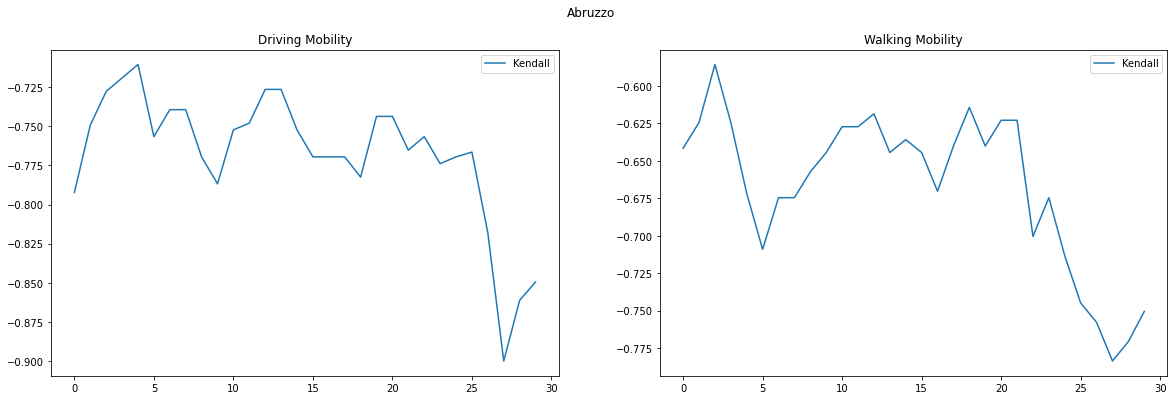

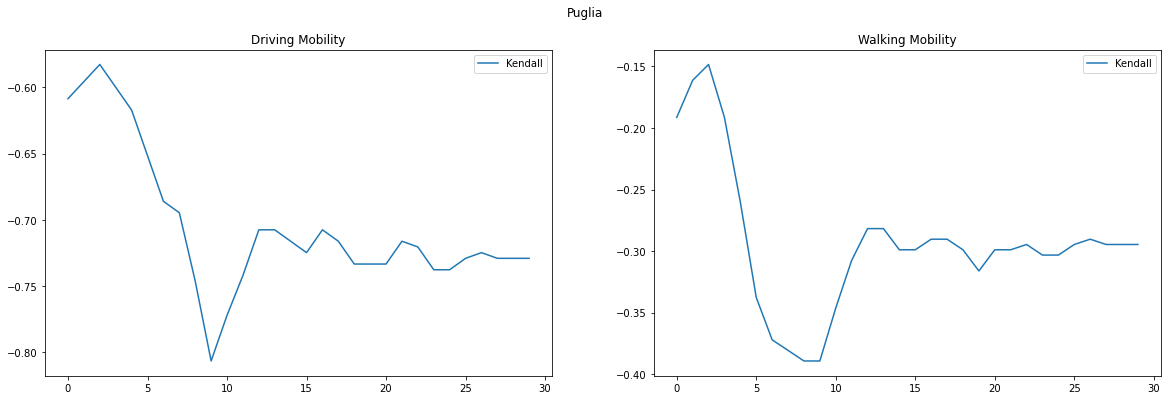

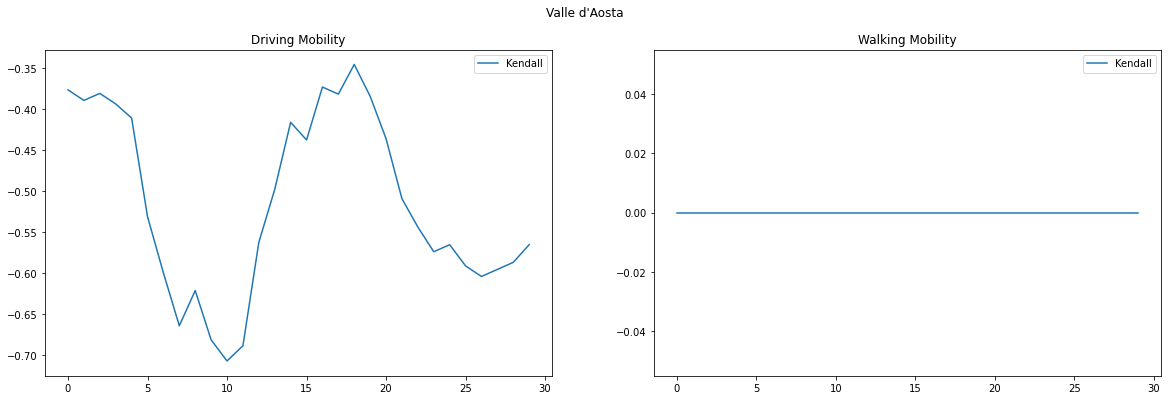

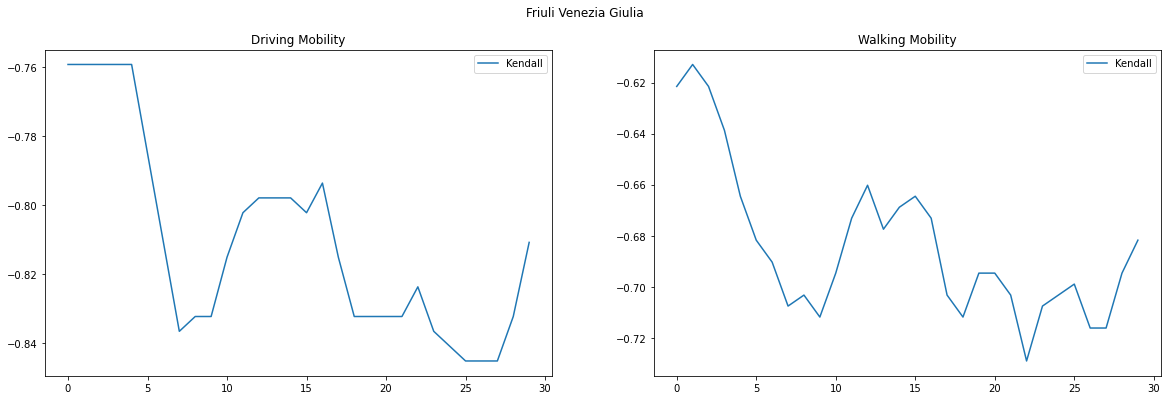

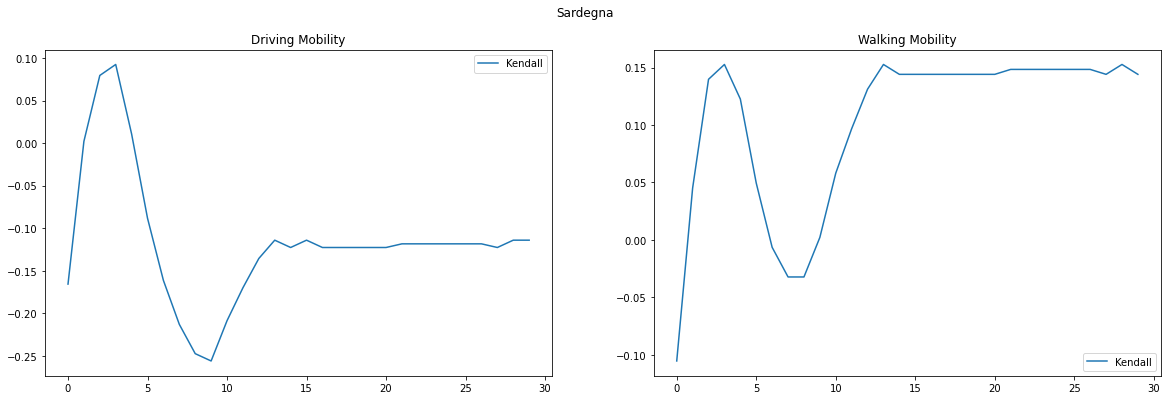

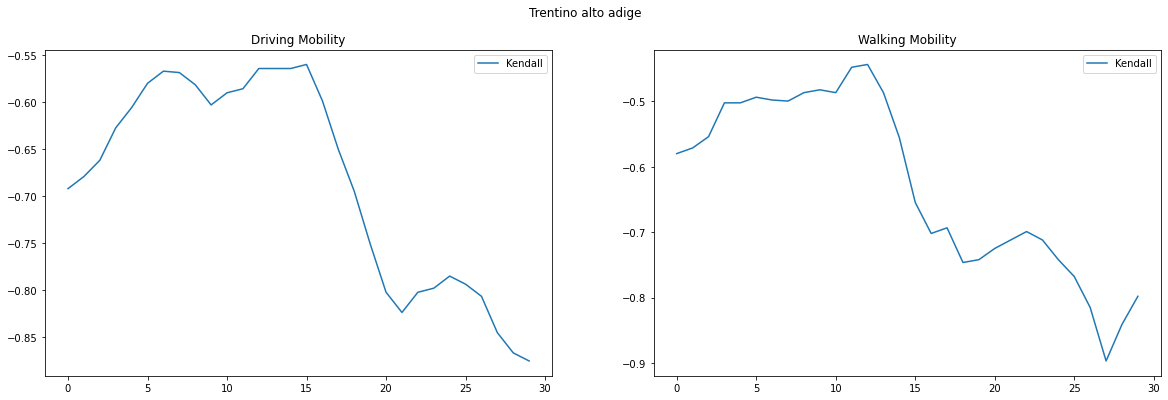

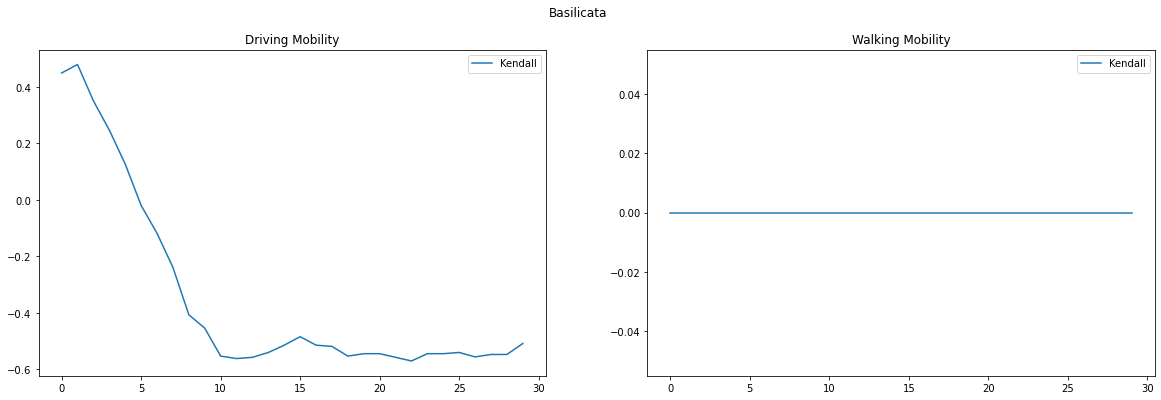

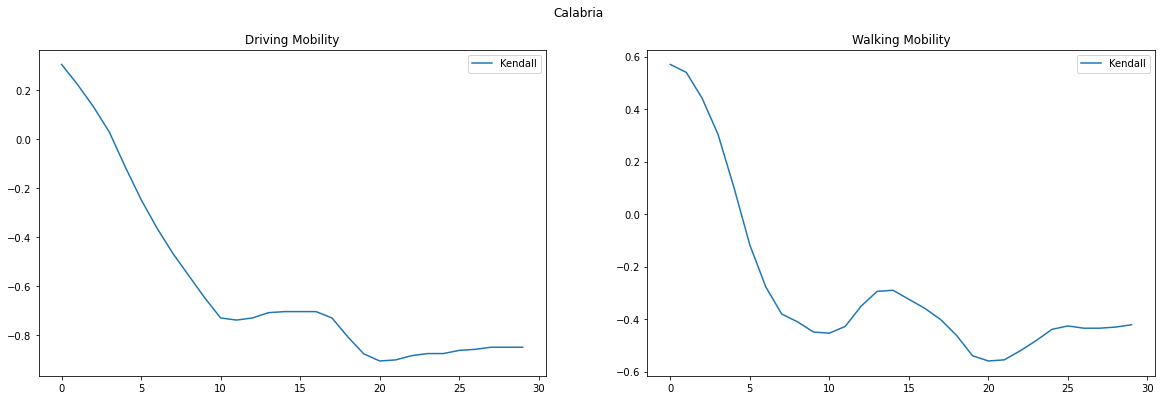

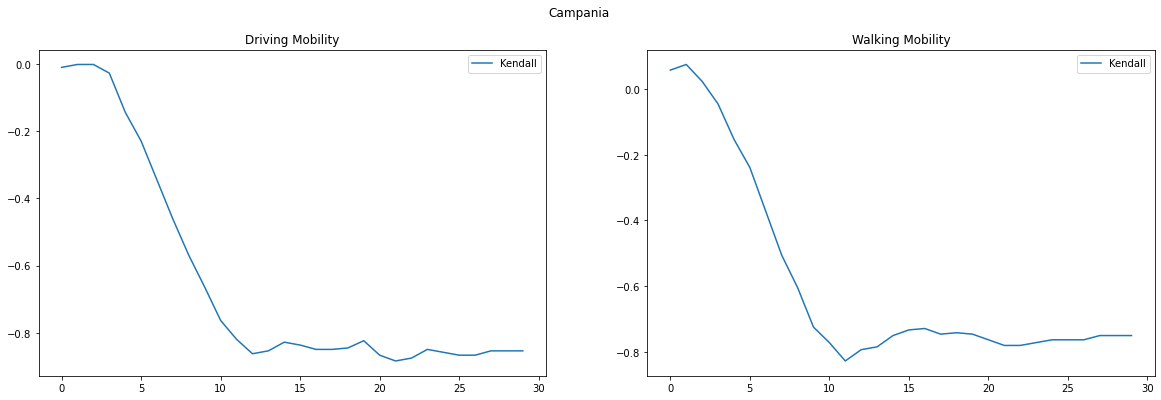

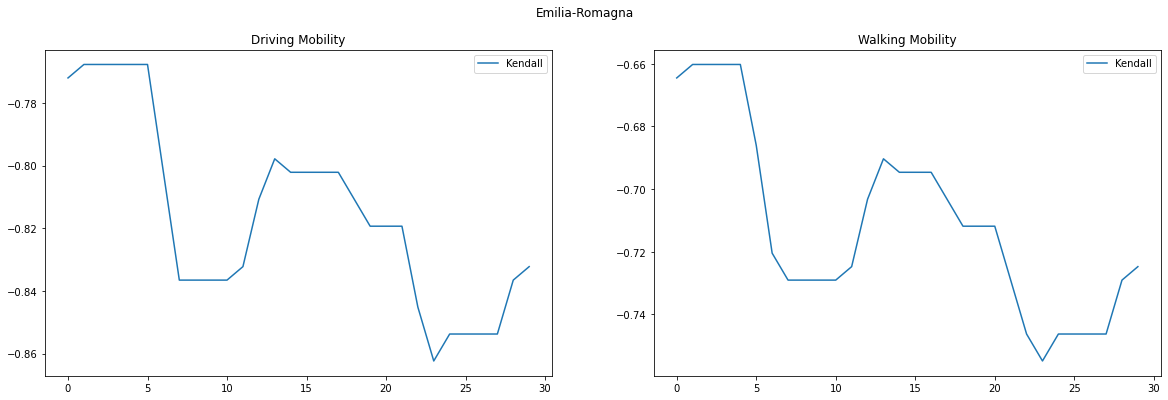

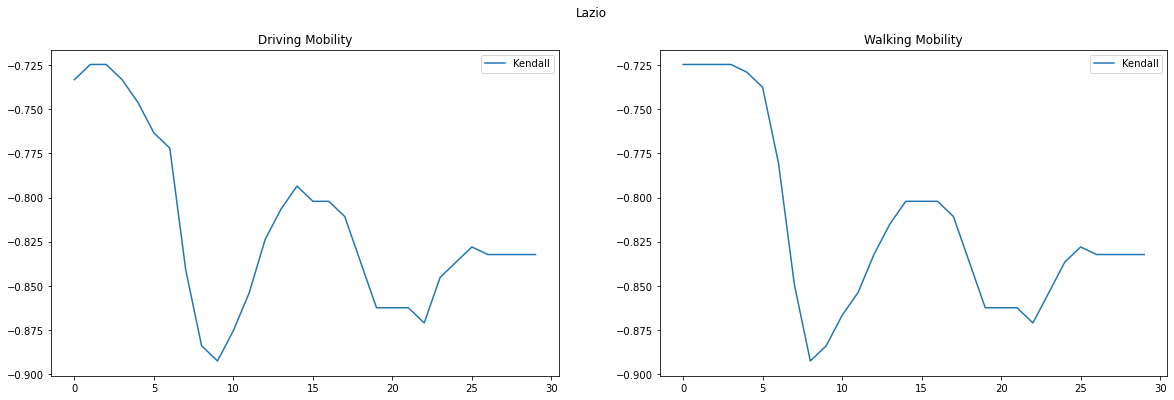

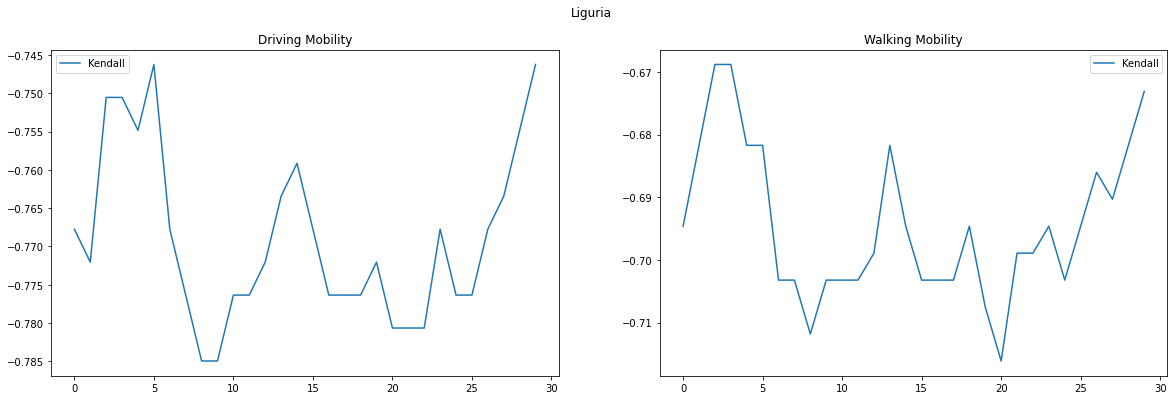

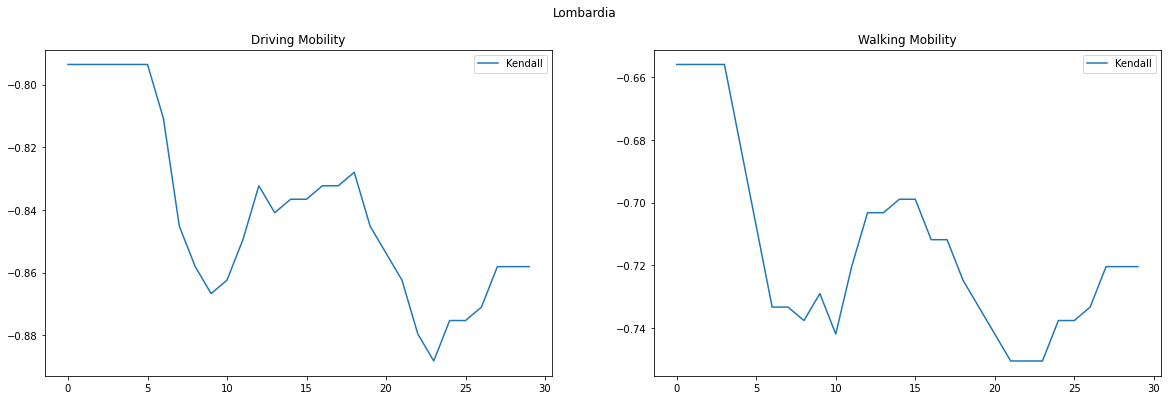

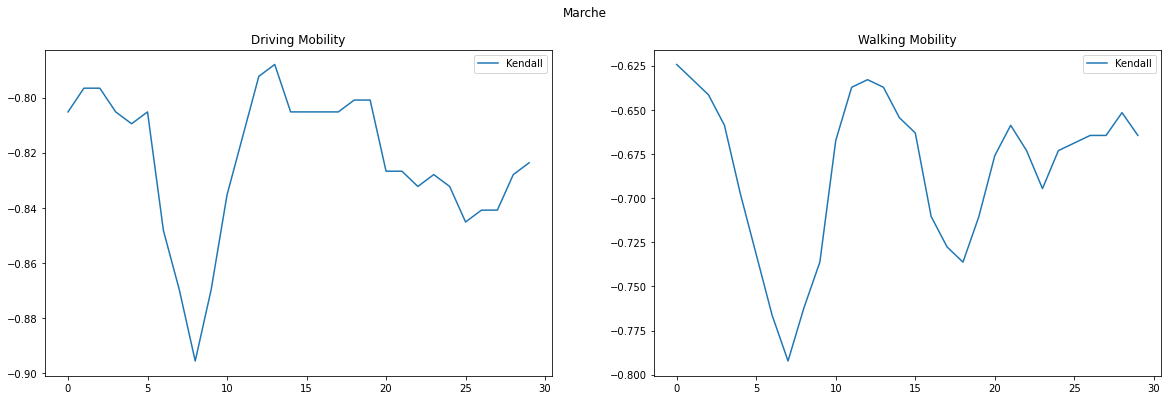

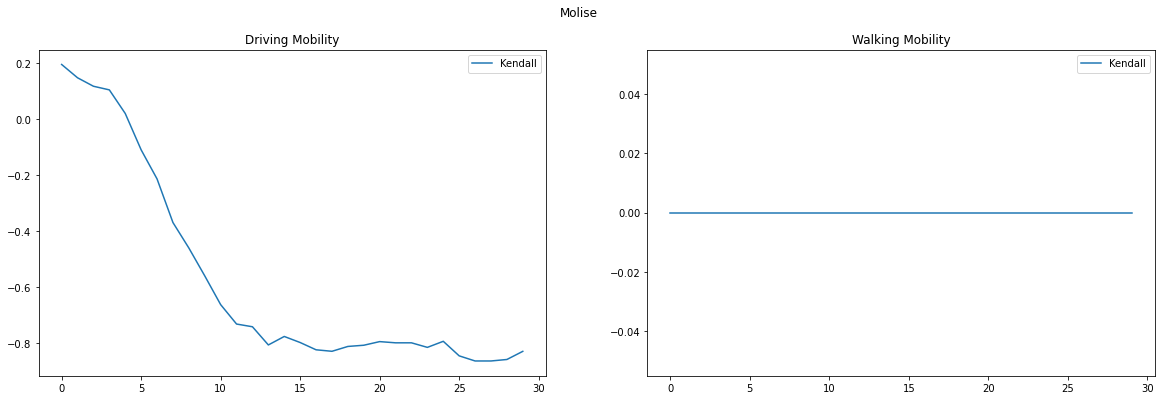

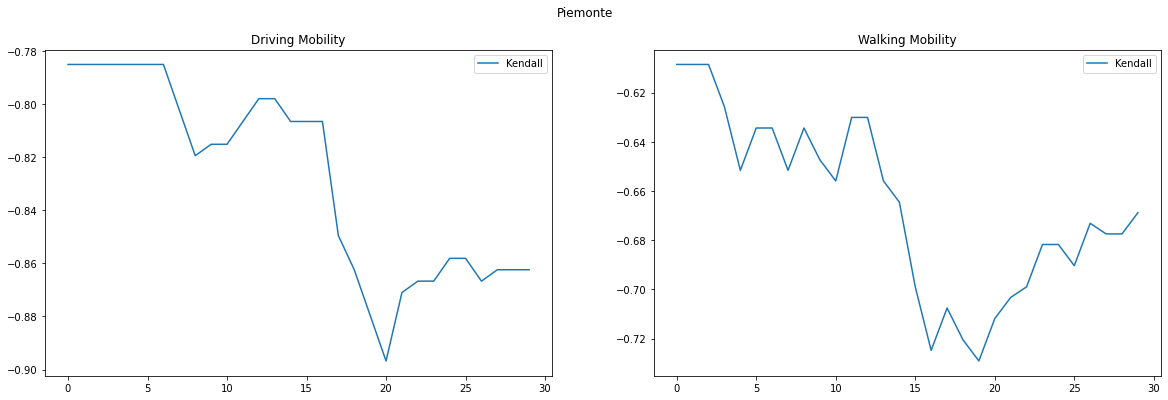

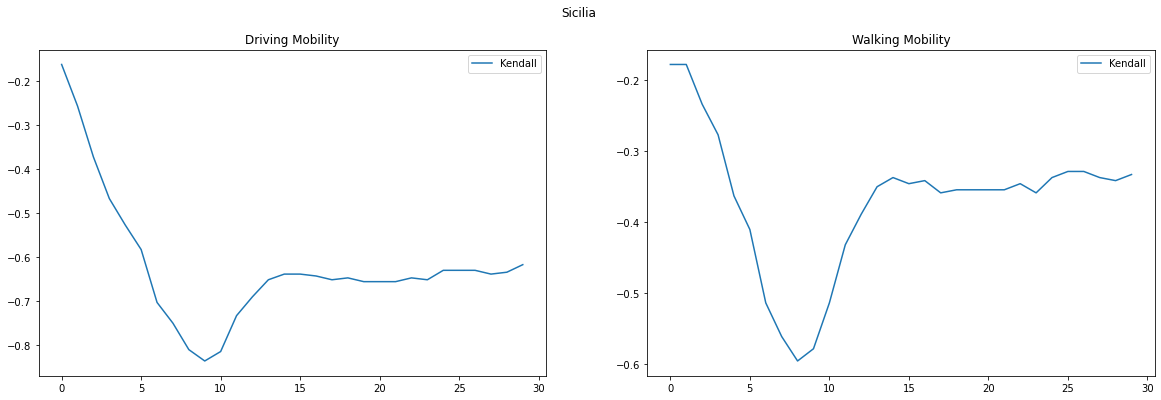

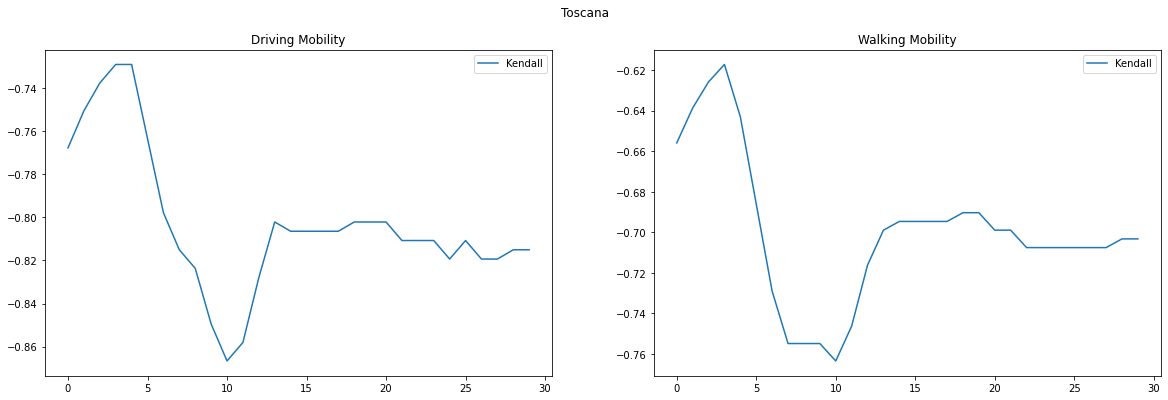

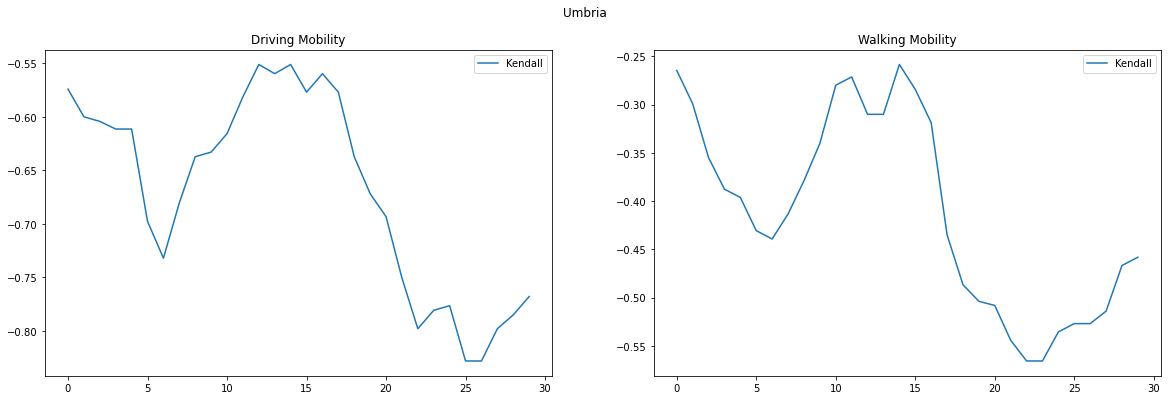

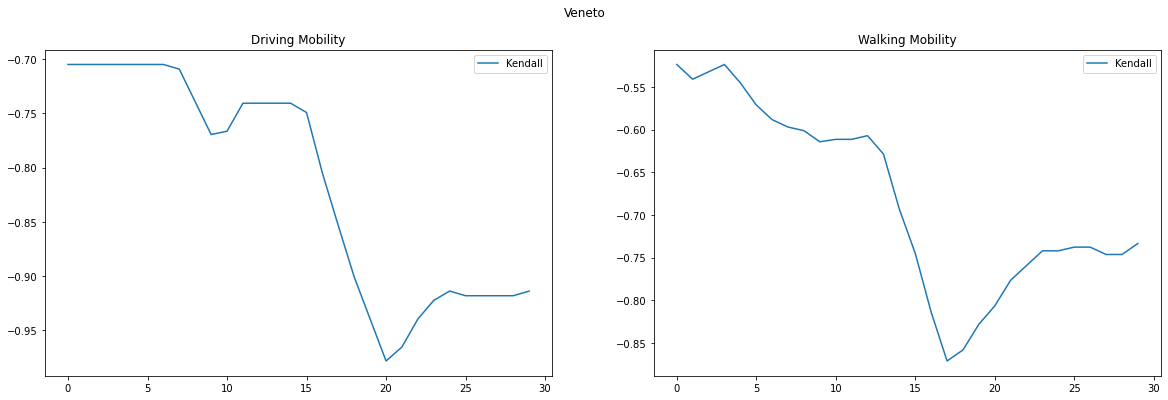

In [87]:
t_start = "2021-04-01"
t_final = "2021-05-01"
lags = np.arange(30)
x_window_slice, x_window_mask = from_to(dates_str_amd, t_start, t_final)
y_window_slice, y_window_mask = from_to(dates_str_pc,  t_start, t_final)


for kk, region_amd in enumerate(region_list_amd):

    # Printing
    fig, ax = plt.subplots(1,2, figsize=[20,6])
    for month in np.arange(1):
        
        driving_spearman = np.zeros((len(lags)))
        walking_spearman = np.zeros((len(lags)))
        driving_kendall  = np.zeros((len(lags)))
        walking_kendall  = np.zeros((len(lags)))
    
        x = applyfilter(df_amd, {"region" : [region_amd]}).iloc[:, 30*month+x_window_mask+2].values#-100
        for ii,lag in enumerate(lags):    
            #y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).iloc[lag+y_window_mask,2].values
            y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).iloc[:,2:].rolling(window=7).mean().iloc[30*month+lag+y_window_mask,0].values
            #driving_spearman[ii] = ss.spearmanr(x[0], y)[0]
            #driving_pearson[ii] = ss.kendalltau(np.diff(x[0]), np.diff(y))[0]
            #driving_kendall[ii]  = ss.kendalltau((x[0]-x[0].mean())/x[0].std(), (y-y.mean())/y.std())[0]
            driving_kendall[ii]  = ss.kendalltau(x[0], y, variant='c')[0]
            try:
                #walking_spearman[ii] = ss.spearmanr(x[1], y)[0]
                walking_kendall[ii]  = ss.kendalltau(x[1], y)[0]
            except Exception:
                pass


        ax[0].plot(lags, driving_kendall,  label="Kendall")
        #ax[0].plot(lags, driving_pearson,  label="Pearson")
        #ax[0].plot(lags, driving_spearman, label="Spearman")
        try:
            #ax[1].plot(lags, walking_spearman, label="Spearman")
            ax[1].plot(lags, walking_kendall,  label="Kendall")
        except Exception:
            pass
        
    ax[0].title.set_text("Driving Mobility")
    ax[1].title.set_text("Walking Mobility")
    ax[0].legend()
    ax[1].legend()
    plt.suptitle(region_sorted_pc[kk])
    plt.show()
    #plt.plot(x[0]/x[0].mean(), label='mobility')
    #plt.plot(y/y.mean(), label='incidence')
    #plt.legend()

In [166]:
region_sorted_pc = ["Abruzzo", "Puglia", "Valle d'Aosta", "Friuli Venezia Giulia",
                    "Sardegna", "Trentino alto adige", "Basilicata", "Calabria", 
                    "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Lombardia", 
                    "Marche", "Molise", "Piemonte", "Sicilia", "Toscana", "Umbria", "V"]

array(['Abruzzo Region', 'Apulia Region',
       'Autonomous Region Aosta Valley',
       'Autonomous Region Friuli-Venezia Giulia',
       'Autonomous Region Sardinia',
       'Autonomous Region Trentino-Alto Adige/Südtirol',
       'Basilicata Region', 'Calabria Region', 'Campania Region',
       'Emilia-Romagna Region', 'Italy', 'Lazio Region', 'Liguria Region',
       'Lombardy Region', 'Marche Region', 'Molise Region',
       'Piedmont Region', 'Sicily Region', 'Tuscany Region',
       'Umbria Region', 'Veneto Region'], dtype=object)

In [44]:
prova = {"driving" : dict(), "walking" : dict()}
prova["driving"]["incidence"] = 33
prova

{'driving': {'incidence': 33}, 'walking': {}}

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


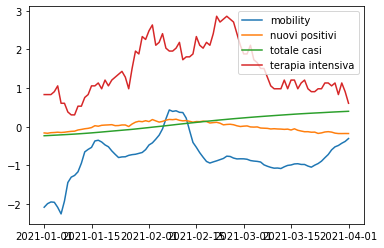

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


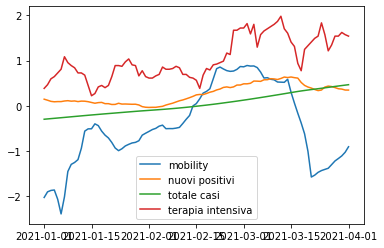

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


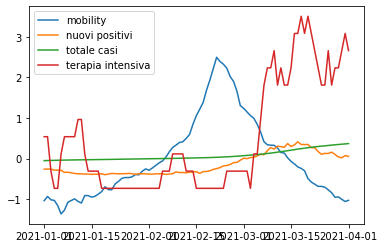

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


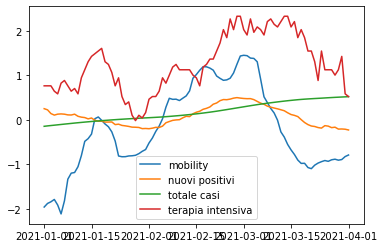

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


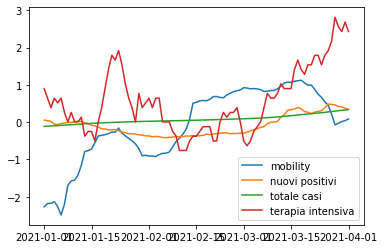

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


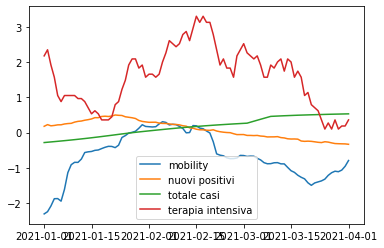

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


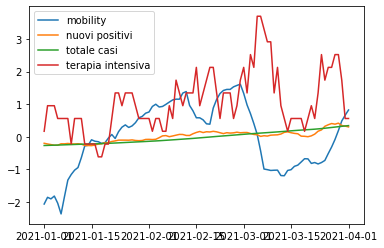

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


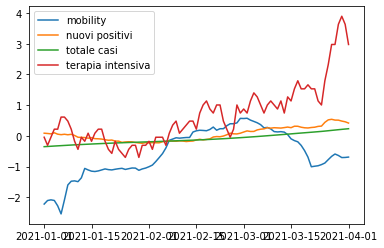

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


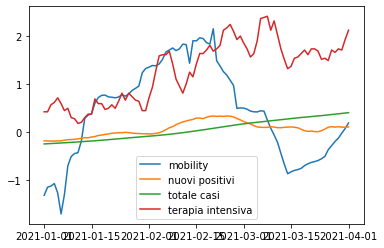

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


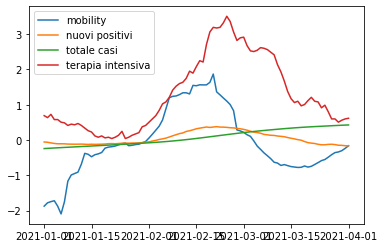

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


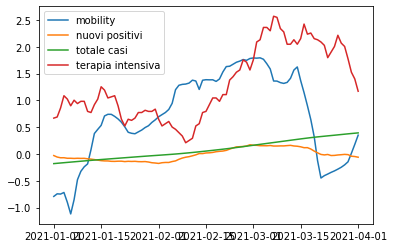

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


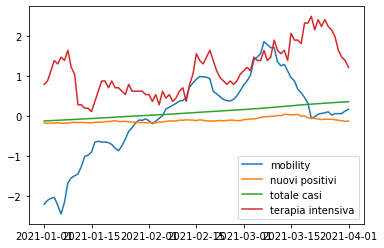

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


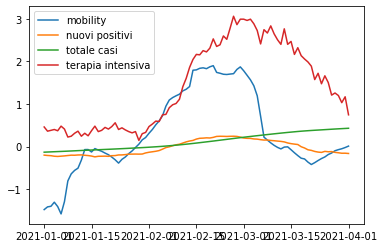

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


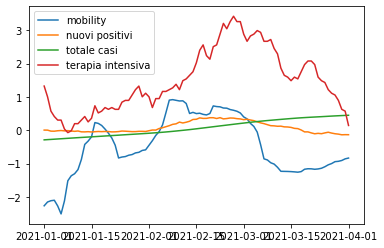

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


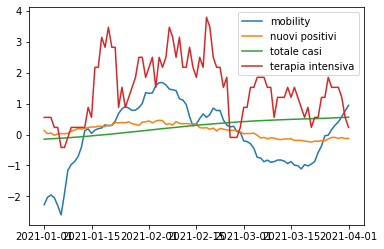

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


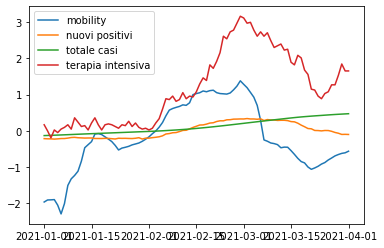

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


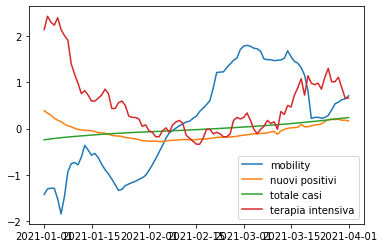

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


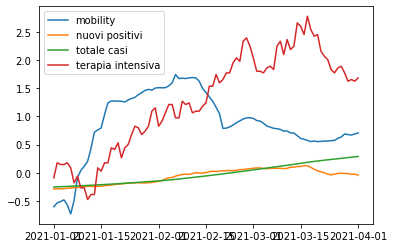

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


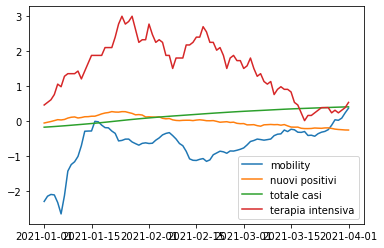

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


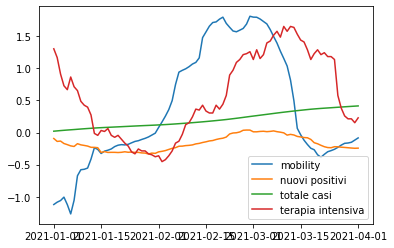

In [77]:
t_start = "2021-01-01"
t_final = "2021-04-01"
x_window_slice, x_window_mask = from_to(dates_str_amd, t_start, t_final)
y_window_slice, y_window_mask = from_to(dates_str_pc,  t_start, t_final)


for kk, region_amd in enumerate(region_list_amd):

        x = applyfilter(df_amd, {"region" : [region_amd]}).iloc[:, x_window_mask+2].values#-100
        y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()
        x = (x-x.mean())/x.std()
        y = (y-y.mean())/y.std()
        plt.plot(dates_datetime_amd[x_window_slice], x[0], label="mobility")
        plt.plot(dates_datetime_pc[y_window_slice], y.iloc[30*month+lag+y_window_mask,0].values, label="nuovi positivi")
        plt.plot(dates_datetime_pc[y_window_slice], y.iloc[30*month+lag+y_window_mask,1].values, label="totale casi")
        plt.plot(dates_datetime_pc[y_window_slice], y.iloc[30*month+lag+y_window_mask,3].values, label="terapia intensiva")
        plt.legend()
        plt.show()

In [168]:
from scipy.signal import correlate, correlation_lags
t_start = "2020-11-03"
t_final = "2020-12-04"
x_window_slice, x_window_mask = from_to(dates_str_amd, t_start, t_final)
y_window_slice, y_window_mask = from_to(dates_str_pc,  t_start, t_final)
a_ext = applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[y_window_mask+14,0].values 
a = applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[y_window_mask,0].values
b = applyfilter(df_amd, {"region" : ["Abruzzo Region"]}).iloc[0, x_window_mask+2].values
a = (a - a.min()) / (a.max() - a.min())
b = (b - b.min()) / (b.max() - b.min())

In [346]:
t_start = "2021-01-04"
t_final = "2021-02-04"
x_window_slice, x_window_mask = from_to(dates_str_amd, t_start, t_final)
y_window_slice, y_window_mask = from_to(dates_str_pc,  t_start, t_final)

lag_corr = np.zeros(50)
for lag in np.arange(50):
    
    #a_ext = applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[y_window_mask+14,0].values 
    a = applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[y_window_mask+lag,0].values
    b = applyfilter(df_amd, {"region" : ["Abruzzo Region"]}).iloc[0, x_window_mask+2].values
    a = (a - a.min()) / (a.max() - a.min())
    b = (b - b.min()) / (b.max() - b.min())
    lag_corr[lag] = sum((a -b)**2)

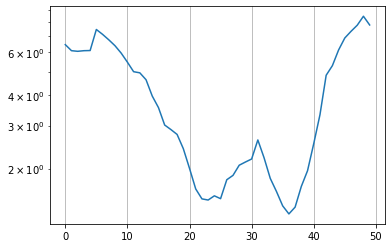

In [347]:
plt.plot(lag_corr)
plt.yscale('log')
plt.grid()

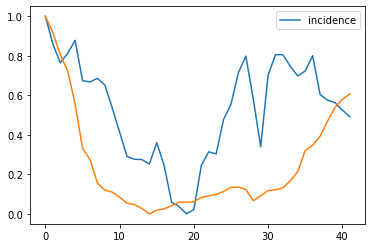

In [327]:
a = applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[y_window_mask+30,0].values
b = applyfilter(df_amd, {"region" : ["Abruzzo Region"]}).iloc[0, x_window_mask+2].values
a = (a - a.min()) / (a.max() - a.min())
b = (b - b.min()) / (b.max() - b.min())
plt.plot(a, label="incidence")
plt.plot(b)
plt.legend()

In [209]:
x_window_mask

array([293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305,
       306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
       319, 320, 321, 322, 323])

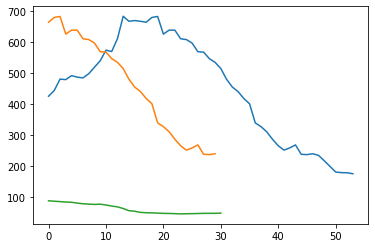

In [220]:
plt.plot(applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[np.arange(251,281+lag),0].values)
plt.plot(applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[np.arange(251,281)+17,0].values)
plt.plot(applyfilter(df_amd, {"region" : ["Abruzzo Region"]}).iloc[0, x_window_mask+2].values)